# Student Information

Wangyang He


UIN 625004872


Nickname: heswaggy

Project submission 10




Resource used to implement my model: [Medium Article](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

Imports

In [ ]:
import keras
import os
import numpy as np
import csv
from keras.applications import VGG16

Download Kinetics 700 Dataset

In [ ]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz


--2021-04-27 23:40:48--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25430997 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.25M  31.2MB/s    in 0.8s    

2021-04-27 23:40:49 (31.2 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25430997/25430997]



un-tar the dataset

In [ ]:
!tar -xvf  'kinetics700_2020.tar.gz' -C '/content'

kinetics700_2020/
kinetics700_2020/validate.json
kinetics700_2020/validate.csv
kinetics700_2020/train.json
kinetics700_2020/train.csv
kinetics700_2020/test.json
kinetics700_2020/test.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/kinetics700_2020/train.csv") #make training dataframe
data.head()

,label,youtube_id,time_start,time_end,split
0,clay pottery making,---0dWlqevI,19,29,train
1,news anchoring,---aQ-tA5_A,9,19,train
2,using bagging machine,---j12rm3WI,14,24,train
3,javelin throw,--07WQ2iBlw,1,11,train
4,climbing a rope,--0NTAs-fA0,29,39,train


In [ ]:
print(data.label)

0           clay pottery making
1                news anchoring
2         using bagging machine
3                 javelin throw
4               climbing a rope
                  ...          
544818           washing dishes
544819            juggling fire
544820             taking photo
544821           brush painting
544822             changing oil
Name: label, Length: 544823, dtype: object


In [ ]:
print(data[data.label == ('washing feet')])

               label   youtube_id  time_start  time_end  split
902     washing feet  -6F0zYW3gUQ         110       120  train
1427    washing feet  -AR-hLSb2Bk          28        38  train
2393    washing feet  -J-DV0OBshM         118       128  train
3635    washing feet  -TPM9qZU7ZQ          15        25  train
4232    washing feet  -ZFww1qGkJs         118       128  train
...              ...          ...         ...       ...    ...
541973  washing feet  zdHU8kuiX98         349       359  train
542346  washing feet  zfW-iqH5fc0          25        35  train
542398  washing feet  zfpK0ulWcT8          42        52  train
544485  washing feet  zwUuMdt295Y          99       109  train
544525  washing feet  zwojAMytFyo         358       368  train

[745 rows x 5 columns]


In [ ]:
data_true = data[data.label == ('washing feet')]
data_true = data_true.reset_index() #get the target label information

In [ ]:
print(data[data.label != ('washing feet')])

                        label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
544818         washing dishes  zzz_3yWpTXo           0        10  train
544819          juggling fire  zzzkS3amkWE         124       134  train
544820           taking photo  zzzsd1R7H0E           6        16  train
544821         brush painting  zzzxltuPx2Q          84        94  train
544822           changing oil  zzzzE0ncP1Y         232       242  train

[544078 rows x 5 columns]


In [ ]:
data_false = data[data.label != ('washing feet')]
data_false = data_false.sample(n=745, random_state=0) # get the same number of un-target label randomly
data_false = data_false.reset_index() 

In [ ]:
data_false.shape

(745, 6)

In [ ]:
data.describe

<bound method NDFrame.describe of                         label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
544818         washing dishes  zzz_3yWpTXo           0        10  train
544819          juggling fire  zzzkS3amkWE         124       134  train
544820           taking photo  zzzsd1R7H0E           6        16  train
544821         brush painting  zzzxltuPx2Q          84        94  train
544822           changing oil  zzzzE0ncP1Y         232       242  train

[544823 rows x 5 columns]>

In [ ]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 8.1MB/s 


In [ ]:
base_dir = '/content/kinetics700' #create all folders for videos
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_true_dir = os.path.join(train_dir, 'true')
os.mkdir(train_true_dir)

train_false_dir = os.path.join(train_dir, 'false')
os.mkdir(train_false_dir)

test_true_dir = os.path.join(test_dir, 'true')
os.mkdir(test_true_dir)

test_false_dir = os.path.join(test_dir, 'false')
os.mkdir(test_false_dir)

In [ ]:
import youtube_dl, subprocess

true_label = ['washing feet'] 
for i, id in data_true.iterrows(): #download training video for target action
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"washing feet.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not washing feet.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -6F0zYW3gUQ: Downloading webpage
[youtube] -6F0zYW3gUQ: Downloading player c59648b4
[youtube] -6F0zYW3gUQ: Downloading MPD manifest
[youtube] -AR-hLSb2Bk: Downloading webpage
[youtube] -J-DV0OBshM: Downloading webpage
[youtube] -J-DV0OBshM: Downloading MPD manifest
[youtube] -TPM9qZU7ZQ: Downloading webpage
[youtube] -TPM9qZU7ZQ: Downloading MPD manifest
[youtube] -ZFww1qGkJs: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] -_q2PvFj5mk: Downloading webpage
[youtube] -_q2PvFj5mk: Downloading MPD manifest
[youtube] -aasN7cTtlA: Downloading webpage
[youtube] -avM04n6GMk: Downloading webpage
[youtube] -avM04n6GMk: Downloading MPD manifest
[youtube] -cTzRqHS9yo: Downloading webpage
[youtube] -gCH1pu1Emo: Downloading webpage
[youtube] -pb4HqQtdVY: Downloading webpage
[youtube] -pb4HqQtdVY: Downloading MPD manifest
[youtube] -qVHzV-ChJw: Downloading webpage
[youtube] -qVHzV-ChJw: Downloading MPD manifest
[youtube] -u59xQTOcmY: Downloading webpage
[youtube] 08aHcnROvfI: Downloading webpage
[youtube] 08aHcnROvfI: Downloading MPD manifest
[youtube] 0CGE6917IZE: Downloading webpage
[youtube] 0CGE6917IZE: Downloading MPD manifest
[youtube] 0DhZ2AhCyuE: Downloading webpage
[youtube] 0Fr4269x-cY: Downloading webpage
[youtube] 0IKgrRWJwXY: Downloading webpage
[youtube] 0IKgrRWJwXY: Downloading MPD manifest
[youtube] 0Mb-4SV_S_I: Downloading webpage
[youtube] 0UPZ3VIZ474: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] 0Yq6RKpUiXI: Downloading webpage
[youtube] 0Yq6RKpUiXI: Downloading MPD manifest
[youtube] 0_T8Jz14vuA: Downloading webpage
[youtube] 0_T8Jz14vuA: Downloading MPD manifest
[youtube] 0adLIg0-PT0: Downloading webpage
[youtube] 0adLIg0-PT0: Downloading MPD manifest
[youtube] 0f7JfOwuxgQ: Downloading webpage
[youtube] 0f7JfOwuxgQ: Downloading MPD manifest
[youtube] 0jf17j8-ixk: Downloading webpage
[youtube] 0vwOrdlqKn0: Downloading webpage
[youtube] 0vwOrdlqKn0: Downloading MPD manifest
[youtube] 13-NS0BX-yk: Downloading webpage
[youtube] 13-NS0BX-yk: Downloading MPD manifest
[youtube] 143RWL3Guqk: Downloading webpage
[youtube] 143RWL3Guqk: Downloading MPD manifest
[youtube] 1D6VUApKJ_M: Downloading webpage
[youtube] 1HVbhXCwzAY: Downloading webpage
[youtube] 1HVbhXCwzAY: Downloading MPD manifest
[youtube] 1I1XVm135qE: Downloading webpage
[youtube] 1R3BZpbJ1WU: Downloading webpage
[youtube] 1YwUmEA6juM: Downloading webpage
[youtube] 1cV4a01mIH4: Downloading webpage
[youtube] 1cV4

ERROR: Video unavailable
This video contains content from OPD, who has blocked it on copyright grounds.


[youtube] 95wgaYgeROk: Downloading webpage
[youtube] 95wgaYgeROk: Downloading MPD manifest
[youtube] 9KxHPzvj8O4: Downloading webpage
[youtube] 9KxHPzvj8O4: Downloading MPD manifest
[youtube] 9O8E2uBM26I: Downloading webpage
[youtube] 9QizaFAsco4: Downloading webpage
[youtube] 9UYnGYH5EUs: Downloading webpage
[youtube] 9UYnGYH5EUs: Downloading MPD manifest
[youtube] 9VRNSHQmni8: Downloading webpage
[youtube] 9VRNSHQmni8: Downloading MPD manifest
[youtube] 9WiBrJ_L_Nc: Downloading webpage
[youtube] 9WiBrJ_L_Nc: Downloading MPD manifest
[youtube] 9ekapq7AlLA: Downloading webpage
[youtube] 9ekapq7AlLA: Downloading MPD manifest
[youtube] 9iF8DAEWPMY: Downloading webpage
[youtube] 9iF8DAEWPMY: Downloading MPD manifest
[youtube] 9ica7JENlKY: Downloading webpage
[youtube] 9ica7JENlKY: Downloading MPD manifest
[youtube] 9kODRofv7Ig: Downloading webpage
[youtube] 9kODRofv7Ig: Downloading MPD manifest
[youtube] 9p2LAtxe4e8: Downloading webpage
[youtube] 9wFD0zGWiSc: Downloading webpage
[youtube]

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Im7zWFicyyk: Downloading webpage
[youtube] Im7zWFicyyk: Downloading MPD manifest
[youtube] IuWNOPgf71Q: Downloading webpage
[youtube] IuWNOPgf71Q: Downloading MPD manifest
[youtube] IwS3O0lg0r0: Downloading webpage
[youtube] IwS3O0lg0r0: Downloading MPD manifest
[youtube] J-uDlEdIFqY: Downloading webpage
[youtube] J-uDlEdIFqY: Downloading MPD manifest
[youtube] J1kJAQEHSlc: Downloading webpage
[youtube] J5dttXMxmqU: Downloading webpage
[youtube] J5dttXMxmqU: Downloading MPD manifest
[youtube] JETRa1ptctU: Downloading webpage
[youtube] JETRa1ptctU: Downloading MPD manifest
[youtube] JHTHl_lUueo: Downloading webpage
[youtube] JR551BJs1zA: Downloading webpage
[youtube] JR551BJs1zA: Downloading MPD manifest
[youtube] JRU_MNjsNO0: Downloading webpage
[youtube] JZxAuUV5jlY: Downloading webpage
[youtube] Jg0hSCjDilY: Downloading webpage
[youtube] Jg0hSCjDilY: Downloading MPD manifest
[youtube] JgJrVjnjqYg: Downloading webpage
[youtube] Ji5tfDErXYA: Downloading webpage
[youtube] Ji5t

ERROR: Video unavailable


[youtube] MGNNuY3dsYI: Downloading webpage
[youtube] MGNNuY3dsYI: Downloading MPD manifest
[youtube] MGNTlNgeHDM: Downloading webpage
[youtube] MGNTlNgeHDM: Downloading MPD manifest
[youtube] MHaTK3e7XjQ: Downloading webpage
[youtube] MHaTK3e7XjQ: Downloading MPD manifest
[youtube] MI0xMG4J-co: Downloading webpage
[youtube] MI0xMG4J-co: Downloading MPD manifest
[youtube] MKYsCZE1srk: Downloading webpage
[youtube] MKYsCZE1srk: Downloading MPD manifest
[youtube] MLHOxTTHkIE: Downloading webpage
[youtube] MLHOxTTHkIE: Downloading MPD manifest
[youtube] MUf4OQDJoME: Downloading webpage
[youtube] MUf4OQDJoME: Downloading MPD manifest
[youtube] MlpTZzdb5nQ: Downloading webpage
[youtube] MlpTZzdb5nQ: Downloading MPD manifest
[youtube] Mznn2Ax1nyw: Downloading webpage
[youtube] N-374Q99QlM: Downloading webpage
[youtube] N-374Q99QlM: Downloading MPD manifest
[youtube] NC0e4KXrp0Y: Downloading webpage
[youtube] NC0e4KXrp0Y: Downloading MPD manifest
[youtube] NGiniedHDkM: Downloading webpage
[you

ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] Tiqse1VDY4U: Downloading webpage
[youtube] Tiqse1VDY4U: Downloading MPD manifest
[youtube] TkYUxMIMXDg: Downloading webpage
[youtube] TmUuI-eMy7c: Downloading webpage
[youtube] TmUuI-eMy7c: Downloading MPD manifest
[youtube] UEdGj1Vz-II: Downloading webpage
[youtube] UEdGj1Vz-II: Downloading MPD manifest
[youtube] UFDNdZ5ASfs: Downloading webpage
[youtube] UFDNdZ5ASfs: Downloading MPD manifest
[youtube] USee25OvZyY: Downloading webpage
[youtube] USee25OvZyY: Downloading MPD manifest
[youtube] UYC0Zi-I3yU: Downloading webpage
[youtube] UYC0Zi-I3yU: Downloading MPD manifest
[youtube] Ubv78SrKqU0: Downloading webpage
[youtube] Ubv78SrKqU0: Downloading MPD manifest
[youtube] UlqgHV0an30: Downloading webpage
[youtube] UlqgHV0an30: Downloading MPD manifest
[youtube] UpDwf1J9YSQ: Downloading webpage
[youtube] UpDwf1J9YSQ: Refetching age-gated info webpage
[youtube] UpDwf1J9YSQ: Downloading MPD manifest
[youtube] Uv8Z1dNCwrc: Downloading webpage
[youtube] Uv8Z1dNCwrc: Downloading MPD

ERROR: Video unavailable


[youtube] WE7dAF_8beo: Downloading webpage
[youtube] WE7dAF_8beo: Downloading MPD manifest
[youtube] WElCDiQwlu4: Downloading webpage
[youtube] WElCDiQwlu4: Downloading MPD manifest
[youtube] WINYbQ2FJyI: Downloading webpage
[youtube] WINYbQ2FJyI: Downloading MPD manifest
[youtube] WIPsczJp_pU: Downloading webpage
[youtube] WIPsczJp_pU: Downloading MPD manifest
[youtube] WQKw-TmKihs: Downloading webpage
[youtube] WQKw-TmKihs: Refetching age-gated info webpage
[youtube] WQKw-TmKihs: Downloading MPD manifest
[youtube] WW0L6N7cbj0: Downloading webpage
[youtube] WW0L6N7cbj0: Downloading MPD manifest
[youtube] WlMz5J0RTP0: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] WnCf5OWt0bQ: Downloading webpage
[youtube] WnCf5OWt0bQ: Downloading MPD manifest
[youtube] Ws4a8KT31m4: Downloading webpage
[youtube] Ws4a8KT31m4: Downloading MPD manifest
[youtube] X6pG-rPYGfE: Downloading webpage
[youtube] X6pG-rPYGfE: Downloading MPD manifest
[youtube] X8OLdR4VcL0: Downloading webpage
[youtube] XAYDxu9eiOw: Downloading webpage
[youtube] XAYDxu9eiOw: Downloading MPD manifest
[youtube] XEE1i8TcOhs: Downloading webpage
[youtube] XWOl7b0G3vE: Downloading webpage
[youtube] XWOl7b0G3vE: Downloading MPD manifest
[youtube] XhrxqVrmsb8: Downloading webpage
[youtube] XhrxqVrmsb8: Downloading MPD manifest
[youtube] XkJ3SEffAUY: Downloading webpage
[youtube] XkJ3SEffAUY: Downloading MPD manifest
[youtube] XlOJsniMsUA: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] XrSOxFP01Tw: Downloading webpage
[youtube] XwKqV9iSTgg: Downloading webpage
[youtube] YAAyPU0gn6g: Downloading webpage
[youtube] YAAyPU0gn6g: Downloading MPD manifest
[youtube] YFVR5y_EtH8: Downloading webpage
[youtube] YFVR5y_EtH8: Downloading MPD manifest
[youtube] YH2UXTWzwhA: Downloading webpage
[youtube] YRvWcA9epZ0: Downloading webpage
[youtube] YRvWcA9epZ0: Downloading MPD manifest
[youtube] YXub0-6AN_M: Downloading webpage
[youtube] YXub0-6AN_M: Downloading MPD manifest
[youtube] YcTXgLaS4ow: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Yd2feQoXzTQ: Downloading webpage
[youtube] Ye6HunHA_mk: Downloading webpage
[youtube] YlNQVgJMHQM: Downloading webpage
[youtube] YqyzOGPuhU0: Downloading webpage
[youtube] YqyzOGPuhU0: Downloading MPD manifest
[youtube] YtoXZ1iBEZc: Downloading webpage
[youtube] Z2kcfUAZRsY: Downloading webpage
[youtube] Z2kcfUAZRsY: Downloading MPD manifest
[youtube] ZWF7aS_eZWI: Downloading webpage
[youtube] ZbgQvcpPf1g: Downloading webpage
[youtube] ZuMjtMVDRMY: Downloading webpage
[youtube] ZxzqOEJLqts: Downloading webpage
[youtube] ZxzqOEJLqts: Downloading MPD manifest
[youtube] _-6lLXKEQhE: Downloading webpage
[youtube] _-6lLXKEQhE: Downloading MPD manifest
[youtube] _5X0pH6aKsg: Downloading webpage
[youtube] _5X0pH6aKsg: Downloading MPD manifest
[youtube] _F64aqcJT_U: Downloading webpage
[youtube] _F64aqcJT_U: Downloading MPD manifest
[youtube] _ILFeR27rv8: Downloading webpage
[youtube] _ILFeR27rv8: Downloading MPD manifest
[youtube] _Qj1VlygJtc: Downloading webpage
[youtube] _Qj1VlygJ

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ep3P3TAeQpM: Downloading webpage
[youtube] ex7CKs50JSk: Downloading webpage
[youtube] f-yuVJDnN8o: Downloading webpage
[youtube] f-yuVJDnN8o: Downloading MPD manifest
[youtube] f0H1ARrjfg0: Downloading webpage
[youtube] f0H1ARrjfg0: Downloading MPD manifest
[youtube] f40IP9TtOJU: Downloading webpage
[youtube] f40IP9TtOJU: Downloading MPD manifest
[youtube] f8J7Kgj8SqU: Downloading webpage
[youtube] f8cxMLmoWes: Downloading webpage
[youtube] f8cxMLmoWes: Downloading MPD manifest
[youtube] fPvZ3GZWNos: Downloading webpage
[youtube] fPvZ3GZWNos: Downloading MPD manifest
[youtube] fWteYjbuRS4: Downloading webpage
[youtube] faH8emmEWP4: Downloading webpage
[youtube] faH8emmEWP4: Downloading MPD manifest
[youtube] feNoivJwvm8: Downloading webpage
[youtube] feNoivJwvm8: Downloading MPD manifest


[youtube] fnAaTL-3P9E: Downloading webpage
[youtube] fxhArffcXZM: Downloading webpage
[youtube] fxhArffcXZM: Downloading MPD manifest
[youtube] g1iJlmxGgn8: Downloading webpage
[youtube] g1iJlmxGgn8: Downloading MPD manifest
[youtube] g2LOPEzrdfc: Downloading webpage
[youtube] g3TSgsdUb8E: Downloading webpage
[youtube] g3TSgsdUb8E: Downloading MPD manifest
[youtube] g3hm1BQq-JI: Downloading webpage
[youtube] g3hm1BQq-JI: Downloading MPD manifest
[youtube] g576HC9DvOM: Downloading webpage
[youtube] g576HC9DvOM: Downloading MPD manifest
[youtube] gGL_S1h_XIg: Downloading webpage
[youtube] gGL_S1h_XIg: Downloading MPD manifest


[youtube] gHszFT6yEIc: Downloading webpage
[youtube] gHszFT6yEIc: Downloading player cb5bd7e6
[youtube] gHszFT6yEIc: Downloading MPD manifest
[youtube] gNhRiNDzfcU: Downloading webpage
[youtube] gNhRiNDzfcU: Downloading MPD manifest
[youtube] gQ7yfyYDun4: Downloading webpage
[youtube] gQ7yfyYDun4: Downloading MPD manifest
[youtube] gRUqx3tN7nY: Downloading webpage
[youtube] gRUqx3tN7nY: Downloading MPD manifest
[youtube] gVIAPjkwrVQ: Downloading webpage
[youtube] gVIAPjkwrVQ: Downloading MPD manifest
[youtube] gcwrSJeTos4: Downloading webpage
[youtube] gcwrSJeTos4: Downloading MPD manifest
[youtube] giWWkUuncVM: Downloading webpage
[youtube] giWWkUuncVM: Downloading MPD manifest
[youtube] gm9jHdY0cV8: Downloading webpage
[youtube] gm9jHdY0cV8: Downloading MPD manifest
[youtube] gp1PDhCiJsU: Downloading webpage
[youtube] gp1PDhCiJsU: Downloading MPD manifest
[youtube] h-Sr3NfJx7M: Downloading webpage
[youtube] h2TdkkHs9rc: Downloading webpage
[youtube] h5oQbHvGWuI: Downloading webpage
[

ERROR: Video unavailable
This video has been removed by the uploader


[youtube] ldiOb99Cpsc: Downloading webpage
[youtube] lgXO9WjS8os: Downloading webpage
[youtube] lgXO9WjS8os: Downloading MPD manifest
[youtube] likZ2s-R_F0: Downloading webpage
[youtube] likZ2s-R_F0: Downloading MPD manifest
[youtube] lkV9qoP7G0I: Downloading webpage
[youtube] lkV9qoP7G0I: Downloading MPD manifest
[youtube] lmllAX_KHNY: Downloading webpage
[youtube] m9huj4FQUE8: Downloading webpage
[youtube] m9huj4FQUE8: Downloading MPD manifest
[youtube] mKhYlRBOAeE: Downloading webpage
[youtube] mKhYlRBOAeE: Downloading MPD manifest
[youtube] mPgXnIjPjH0: Downloading webpage
[youtube] mPo7lljFpZM: Downloading webpage
[youtube] mPo7lljFpZM: Downloading MPD manifest
[youtube] mRPb9KjR_mc: Downloading webpage
[youtube] mfT2tlf8RAA: Downloading webpage
[youtube] mfT2tlf8RAA: Downloading MPD manifest
[youtube] msaU6yR3bA4: Downloading webpage
[youtube] msaU6yR3bA4: Downloading MPD manifest
[youtube] mz8lM3ABzSY: Downloading webpage
[youtube] n3vpap_pQ-U: Downloading webpage
[youtube] nAXb

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] oheempdvw4o: Downloading webpage
[youtube] oheempdvw4o: Downloading MPD manifest
[youtube] onGJiZIKkDQ: Downloading webpage
[youtube] onGJiZIKkDQ: Downloading MPD manifest
[youtube] op1lEZZQChk: Downloading webpage
[youtube] op1lEZZQChk: Downloading MPD manifest
[youtube] oqww-DdJLzI: Downloading webpage
[youtube] oqww-DdJLzI: Downloading MPD manifest
[youtube] ox1BBkLm47g: Downloading webpage
[youtube] ox1BBkLm47g: Downloading MPD manifest
[youtube] oxjHs0ibufw: Downloading webpage
[youtube] oxjHs0ibufw: Downloading MPD manifest
[youtube] oyS5Nng6Vpk: Downloading webpage
[youtube] p5FvsUNixsM: Downloading webpage
[youtube] p5FvsUNixsM: Downloading MPD manifest
[youtube] pEJRYt9RXbc: Downloading webpage
[youtube] pF8WRI2E790: Downloading webpage
[youtube] pF8WRI2E790: Refetching age-gated info webpage
[youtube] pGxJnS6S4j0: Downloading webpage
[youtube] pGxJnS6S4j0: Downloading MPD manifest
[youtube] pHZjdz9ZbSw: Downloading webpage
[youtube] pXVBSEYnQAw: Downloading webpage


[youtube] rg6OnVUA4M0: Downloading webpage
[youtube] rg6OnVUA4M0: Downloading MPD manifest
[youtube] rlMX01_SBHM: Downloading webpage
[youtube] rlMX01_SBHM: Downloading MPD manifest


[youtube] rlMyN6kQMqY: Downloading webpage
[youtube] rlMyN6kQMqY: Downloading MPD manifest
[youtube] rqfMvqJ4fJM: Downloading webpage
[youtube] ru8wKwJg3LY: Downloading webpage
[youtube] ru8wKwJg3LY: Downloading MPD manifest
[youtube] rz_LukG443o: Downloading webpage
[youtube] s0YCHPXWfM8: Downloading webpage
[youtube] sDAwzyKuOPk: Downloading webpage
[youtube] sDAwzyKuOPk: Downloading MPD manifest
[youtube] sNXNYsnNYT8: Downloading webpage
[youtube] sNXNYsnNYT8: Downloading MPD manifest
[youtube] sQfg-eqFxj4: Downloading webpage
[youtube] sTCKuiXcimM: Downloading webpage
[youtube] sTCKuiXcimM: Downloading MPD manifest
[youtube] saTpbYGGU1M: Downloading webpage
[youtube] sb36jyjeLrw: Downloading webpage
[youtube] shZHx_2eh9c: Downloading webpage
[youtube] shZHx_2eh9c: Downloading MPD manifest
[youtube] sj-D0MlyTBk: Downloading webpage
[youtube] smw6zeckrlc: Downloading webpage
[youtube] ssE6TITrjOQ: Downloading webpage
[youtube] sySODAj8mvc: Downloading webpage
[youtube] t0CR0XdDpyU: D

[youtube] xUexafXPioE: Downloading webpage
[youtube] xUexafXPioE: Downloading MPD manifest
[youtube] xYzWvHgkJLs: Downloading webpage
[youtube] xejjQlACIaE: Downloading webpage
[youtube] xejjQlACIaE: Downloading MPD manifest
[youtube] xes_HJYdxsU: Downloading webpage
[youtube] xiUjWfplK80: Downloading webpage
[youtube] xizfMeo6HVE: Downloading webpage
[youtube] xizfMeo6HVE: Downloading MPD manifest
[youtube] xmHspKNihAg: Downloading webpage
[youtube] xoQnV6DGf3c: Downloading webpage
[youtube] xoQnV6DGf3c: Downloading MPD manifest
[youtube] y4qw8z3dIOI: Downloading webpage
[youtube] y4qw8z3dIOI: Downloading MPD manifest
[youtube] y8KPWrR2zjo: Downloading webpage
[youtube] yDLx4lfq-Fw: Downloading webpage


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] yGbJbOdUPEI: Downloading webpage
[youtube] yHCXaKUNRMI: Downloading webpage
[youtube] yKRxTQgK0DI: Downloading webpage
[youtube] yKRxTQgK0DI: Downloading MPD manifest
[youtube] yKjbEcEiP6I: Downloading webpage
[youtube] yMGB45IT4h4: Downloading webpage
[youtube] yMGB45IT4h4: Downloading MPD manifest
[youtube] yQx7iqHu4sI: Downloading webpage
[youtube] yUuwH7EJ2Vg: Downloading webpage
[youtube] yUuwH7EJ2Vg: Downloading MPD manifest
[youtube] yVltEn6u_2A: Downloading webpage
[youtube] yWv1d-_j15U: Downloading webpage
[youtube] yWwY2CLkxP8: Downloading webpage
[youtube] yWwY2CLkxP8: Downloading MPD manifest
[youtube] yXW7CwtDg3M: Downloading webpage
[youtube] yXu9fr1RZSM: Downloading webpage
[youtube] yXu9fr1RZSM: Downloading MPD manifest
[youtube] yqgDEYw8RtA: Downloading webpage
[youtube] yqgDEYw8RtA: Downloading MPD manifest
[youtube] yqzTHqzZdgc: Downloading webpage
[youtube] yzgAuqFpirM: Downloading webpage
[youtube] z62hC-8OJZs: Downloading webpage
[youtube] zJrFmVn7ndE: D

In [ ]:
true_label = ['washing feet']
for i, id in data_false.iterrows(): #get un-target training videos
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"washing feet.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not washing feet.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] uDWzYXhl0vk: Downloading webpage
[youtube] uDWzYXhl0vk: Downloading MPD manifest
[youtube] YbL267l99F4: Downloading webpage
[youtube] g0rdr1dNwvA: Downloading webpage
[youtube] GB06v6modHU: Downloading webpage
[youtube] GB06v6modHU: Downloading MPD manifest
[youtube] udK33qzFG1M: Downloading webpage


ERROR: This video has been removed for violating YouTube's policy on violent or graphic content.


[youtube] e3a4BlbWq-0: Downloading webpage
[youtube] P0Q8aamgKEw: Downloading webpage
[youtube] QBF1YfIassY: Downloading webpage
[youtube] QBF1YfIassY: Downloading MPD manifest
[youtube] PVw05byU-f4: Downloading webpage
[youtube] PVw05byU-f4: Downloading MPD manifest
[youtube] Pmed6S1Nb6A: Downloading webpage
[youtube] Pmed6S1Nb6A: Downloading MPD manifest
[youtube] k4S2r_Y5TVI: Downloading webpage
[youtube] k4S2r_Y5TVI: Downloading MPD manifest
[youtube] 52_wb7XwEVM: Downloading webpage
[youtube] 52_wb7XwEVM: Downloading MPD manifest
[youtube] RmYg6k4wU7Q: Downloading webpage
[youtube] RmYg6k4wU7Q: Downloading MPD manifest
[youtube] yslAGmLbV48: Downloading webpage
[youtube] yslAGmLbV48: Downloading MPD manifest
[youtube] GAntlvymt7M: Downloading webpage
[youtube] tTJVdi7mqWU: Downloading webpage
[youtube] tTJVdi7mqWU: Downloading MPD manifest
[youtube] aIfdY1SZxT4: Downloading webpage
[youtube] 5fbWhUMiRoc: Downloading webpage
[youtube] gDRS55kmAw4: Downloading webpage
[youtube] gDRS

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] V1_NjGVFmvs: Downloading webpage
[youtube] c-h4BLEtifg: Downloading webpage
[youtube] c-h4BLEtifg: Downloading MPD manifest
[youtube] mdd6nzX7yUM: Downloading webpage
[youtube] mdd6nzX7yUM: Downloading MPD manifest
[youtube] moEfKE4KiXA: Downloading webpage
[youtube] moEfKE4KiXA: Downloading MPD manifest
[youtube] qgAlg6Ngn_s: Downloading webpage
[youtube] qgAlg6Ngn_s: Downloading MPD manifest
[youtube] wibHN8rY3Ls: Downloading webpage
[youtube] wibHN8rY3Ls: Downloading MPD manifest
[youtube] W0DaA4kVxDY: Downloading webpage
[youtube] W0DaA4kVxDY: Downloading MPD manifest
[youtube] Cn3UnWM8ooE: Downloading webpage
[youtube] Cn3UnWM8ooE: Downloading MPD manifest
[youtube] reIf3kUZ7uk: Downloading webpage
[youtube] yWgkJlUOcv0: Downloading webpage
[youtube] yWgkJlUOcv0: Downloading MPD manifest
[youtube] oCvOnRmvYMU: Downloading webpage
[youtube] oCvOnRmvYMU: Downloading MPD manifest
[youtube] rxpyKNDaNoc: Downloading webpage
[youtube] rxpyKNDaNoc: Downloading MPD manifest
[you

ERROR: Video unavailable


[youtube] LVUVD02-1A4: Downloading webpage
[youtube] CzpGNDTb7bw: Downloading webpage
[youtube] ef-8QfgEAy4: Downloading webpage
[youtube] ef-8QfgEAy4: Downloading MPD manifest
[youtube] ZlvCLqybTbU: Downloading webpage
[youtube] ZlvCLqybTbU: Downloading MPD manifest
[youtube] 8HEYWdpKc8E: Downloading webpage
[youtube] qttaQEUq6fM: Downloading webpage
[youtube] qttaQEUq6fM: Downloading MPD manifest
[youtube] y5bIU7VTVdo: Downloading webpage
[youtube] y5bIU7VTVdo: Downloading MPD manifest
[youtube] pbhPNQgNZ0E: Downloading webpage
[youtube] pbhPNQgNZ0E: Downloading MPD manifest
[youtube] wbV39tqnaLw: Downloading webpage
[youtube] wbV39tqnaLw: Downloading MPD manifest
[youtube] EBJlym6Qctw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] T470ojnnDI4: Downloading webpage
[youtube] T470ojnnDI4: Downloading MPD manifest
[youtube] I5Jf5GnQ4i0: Downloading webpage
[youtube] I5Jf5GnQ4i0: Downloading MPD manifest
[youtube] eqHaqn8OQOU: Downloading webpage
[youtube] eqHaqn8OQOU: Downloading MPD manifest
[youtube] EMEwB82paHY: Downloading webpage
[youtube] rF_r_mm-TE0: Downloading webpage
[youtube] rF_r_mm-TE0: Downloading MPD manifest
[youtube] 3p5ax0aELc0: Downloading webpage
[youtube] 3p5ax0aELc0: Downloading MPD manifest
[youtube] qv_erPwZIW0: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 6sUNprmOnT0: Downloading webpage
[youtube] 6sUNprmOnT0: Downloading MPD manifest
[youtube] 7X0GfE0irwg: Downloading webpage
[youtube] _UyZpt0Qbnk: Downloading webpage
[youtube] _UyZpt0Qbnk: Downloading MPD manifest
[youtube] jdYmqUWagDk: Downloading webpage
[youtube] u50Y27IGhQI: Downloading webpage
[youtube] u50Y27IGhQI: Downloading MPD manifest
[youtube] ETobiXC0rc4: Downloading webpage
[youtube] ETobiXC0rc4: Downloading MPD manifest
[youtube] YZFdeeVaMNw: Downloading webpage
[youtube] o6pTZ3mVaSs: Downloading webpage
[youtube] o6pTZ3mVaSs: Downloading MPD manifest
[youtube] MBHULY7KpjU: Downloading webpage
[youtube] MBHULY7KpjU: Downloading MPD manifest
[youtube] T8JJuUPmR4s: Downloading webpage
[youtube] OegoxK2rWBQ: Downloading webpage
[youtube] OegoxK2rWBQ: Downloading MPD manifest
[youtube] zCIpMmZeESo: Downloading webpage
[youtube] Fw_9Vbg_6tk: Downloading webpage
[youtube] s8aR906-9go: Downloading webpage
[youtube] s8aR906-9go: Downloading MPD manifest
[youtube] BuNb

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] sFICajq-dAk: Downloading webpage
[youtube] sFICajq-dAk: Downloading MPD manifest
[youtube] thtQMkTJDFg: Downloading webpage
[youtube] thtQMkTJDFg: Downloading MPD manifest
[youtube] Mryc-_He8cQ: Downloading webpage
[youtube] 7AcLWp1B6t0: Downloading webpage
[youtube] 7AcLWp1B6t0: Downloading MPD manifest
[youtube] DSyfXvQXRt8: Downloading webpage
[youtube] RuED175qMHo: Downloading webpage
[youtube] RuED175qMHo: Downloading MPD manifest
[youtube] SfvXLSZTA_w: Downloading webpage
[youtube] SfvXLSZTA_w: Downloading MPD manifest
[youtube] rVxiG4HiMqs: Downloading webpage
[youtube] rVxiG4HiMqs: Downloading MPD manifest
[youtube] qfU-PMcCnck: Downloading webpage
[youtube] FBrWWkV4I4A: Downloading webpage
[youtube] FBrWWkV4I4A: Downloading MPD manifest
[youtube] 6IR-XbljEIk: Downloading webpage
[youtube] yP8aii4xmP4: Downloading webpage
[youtube] yP8aii4xmP4: Downloading MPD manifest
[youtube] apCAWnC1F70: Downloading webpage
[youtube] apCAWnC1F70: Downloading MPD manifest
[youtube]

ERROR: Video unavailable
This video is not available


[youtube] V6cisvYfXag: Downloading webpage
[youtube] hadS2RtKWf0: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4yV_tPg-Z4k: Downloading webpage
[youtube] 4yV_tPg-Z4k: Downloading MPD manifest
[youtube] 3ejX7BZlJBY: Downloading webpage
[youtube] xjN4sD53UmI: Downloading webpage
[youtube] swtdpngTqt0: Downloading webpage
[youtube] rI7Ahm8oiqI: Downloading webpage
[youtube] rI7Ahm8oiqI: Downloading MPD manifest
[youtube] dKxS-9QNR7I: Downloading webpage


ERROR: Video unavailable


[youtube] CGCwnS5a3oA: Downloading webpage
[youtube] R85wkUlNKdc: Downloading webpage
[youtube] n7-DbEBcRGU: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] JrLozomMy1Y: Downloading webpage
[youtube] JrLozomMy1Y: Downloading MPD manifest
[youtube] nxl-ZALkycI: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] uXLtpb4ScQI: Downloading webpage
[youtube] uXLtpb4ScQI: Downloading MPD manifest
[youtube] 2dufB6hb7bA: Downloading webpage
[youtube] 2dufB6hb7bA: Downloading MPD manifest
[youtube] wJgV2rJ_8OY: Downloading webpage
[youtube] p04l8rElHWE: Downloading webpage
[youtube] p04l8rElHWE: Downloading MPD manifest
[youtube] ic8ueJsQaGw: Downloading webpage
[youtube] MGmGZc-wC1o: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] mOt0VMVkq2A: Downloading webpage
[youtube] mOt0VMVkq2A: Downloading MPD manifest
[youtube] LDbNGjh6KoE: Downloading webpage
[youtube] LDbNGjh6KoE: Downloading MPD manifest
[youtube] 8Ow3ROsEk5M: Downloading webpage


ERROR: Video unavailable


[youtube] va0k9XDlKR0: Downloading webpage
[youtube] va0k9XDlKR0: Downloading MPD manifest
[youtube] BbvesAstVTI: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] E0oDV3tVQeI: Downloading webpage
[youtube] E0oDV3tVQeI: Downloading MPD manifest
[youtube] GhFR9lGvG-E: Downloading webpage
[youtube] GhFR9lGvG-E: Downloading MPD manifest
[youtube] iSuly95okpc: Downloading webpage
[youtube] 4duBoL8mOh8: Downloading webpage
[youtube] 4duBoL8mOh8: Downloading MPD manifest
[youtube] 7CqKpquSHCs: Downloading webpage
[youtube] 7CqKpquSHCs: Downloading MPD manifest
[youtube] wmGbnk1xfMY: Downloading webpage
[youtube] wmGbnk1xfMY: Downloading MPD manifest
[youtube] i2Y0nHo9ujc: Downloading webpage
[youtube] JJdCboFiArY: Downloading webpage
[youtube] -CMo6AJhtZo: Downloading webpage
[youtube] UUf9guWyG4I: Downloading webpage
[youtube] UUf9guWyG4I: Downloading MPD manifest
[youtube] f3Wa7ttGrgg: Downloading webpage
[youtube] f3Wa7ttGrgg: Downloading MPD manifest
[youtube] nCrtCRVWvLU: Downloading webpage
[youtube] lZTHWy2B-EM: Downloading webpage
[youtube] YFYjP6LTii0: Downloading webpage
[youtube] YFYjP6LTii0: Downloading MPD manifest
[youtube] 82Va

ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] RmJ4pdvLnRo: Downloading webpage
[youtube] RmJ4pdvLnRo: Downloading MPD manifest
[youtube] 5zaDvzTroUk: Downloading webpage
[youtube] 5zaDvzTroUk: Downloading MPD manifest
[youtube] ulAxKIQgyXc: Downloading webpage
[youtube] ulAxKIQgyXc: Downloading MPD manifest
[youtube] YrgOFrjQZrc: Downloading webpage


[youtube] YrgOFrjQZrc: Downloading API JSON
[youtube] YrgOFrjQZrc: Downloading MPD manifest
[youtube] YrgOFrjQZrc: Downloading API JSON
[youtube] zZM93RuIdeI: Downloading webpage


[youtube] zZM93RuIdeI: Downloading API JSON
[youtube] zZM93RuIdeI: Downloading MPD manifest
[youtube] zZM93RuIdeI: Downloading API JSON
[youtube] PONvvWGBHRA: Downloading webpage


[youtube] PONvvWGBHRA: Downloading API JSON
[youtube] PONvvWGBHRA: Downloading MPD manifest
[youtube] PONvvWGBHRA: Downloading API JSON
[youtube] pANIZRlpbP8: Downloading webpage


[youtube] pANIZRlpbP8: Downloading API JSON
[youtube] pANIZRlpbP8: Downloading MPD manifest
[youtube] pANIZRlpbP8: Downloading API JSON


ERROR: requested format not available


[youtube] ffghuKE5B48: Downloading webpage


[youtube] ffghuKE5B48: Downloading API JSON
[youtube] ffghuKE5B48: Downloading MPD manifest
[youtube] ffghuKE5B48: Downloading API JSON
[youtube] D0KwubYfSUs: Downloading webpage


[youtube] D0KwubYfSUs: Downloading API JSON
[youtube] D0KwubYfSUs: Downloading MPD manifest
[youtube] D0KwubYfSUs: Downloading API JSON
[youtube] WJ2o167Nf50: Downloading webpage


[youtube] WJ2o167Nf50: Downloading API JSON
[youtube] WJ2o167Nf50: Downloading MPD manifest
[youtube] WJ2o167Nf50: Downloading API JSON
[youtube] 0rfCZrRmMZk: Downloading webpage


[youtube] 0rfCZrRmMZk: Downloading API JSON
[youtube] 0rfCZrRmMZk: Downloading MPD manifest
[youtube] 0rfCZrRmMZk: Downloading API JSON
[youtube] Va8r1IywC7A: Downloading webpage


[youtube] Va8r1IywC7A: Downloading API JSON
[youtube] Va8r1IywC7A: Downloading MPD manifest
[youtube] Va8r1IywC7A: Downloading API JSON
[youtube] N04NNyZ8KSI: Downloading webpage


[youtube] N04NNyZ8KSI: Downloading API JSON
[youtube] N04NNyZ8KSI: Downloading MPD manifest
[youtube] N04NNyZ8KSI: Downloading API JSON
[youtube] KY_wEez8kEc: Downloading webpage


[youtube] KY_wEez8kEc: Downloading API JSON
[youtube] KY_wEez8kEc: Downloading MPD manifest
[youtube] KY_wEez8kEc: Downloading API JSON
[youtube] PsbMnziFvDM: Downloading webpage


[youtube] PsbMnziFvDM: Downloading API JSON
[youtube] PsbMnziFvDM: Downloading API JSON
[youtube] l2NCDJOmaOM: Downloading webpage


[youtube] l2NCDJOmaOM: Downloading API JSON
[youtube] l2NCDJOmaOM: Downloading API JSON
[youtube] AhRXTbxl9TA: Downloading webpage


[youtube] AhRXTbxl9TA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 8jjv1NBipm4: Downloading webpage


[youtube] 8jjv1NBipm4: Downloading API JSON
[youtube] 8jjv1NBipm4: Downloading MPD manifest
[youtube] 8jjv1NBipm4: Downloading API JSON
[youtube] kopmw2XYg-4: Downloading webpage


[youtube] kopmw2XYg-4: Downloading API JSON
[youtube] kopmw2XYg-4: Downloading MPD manifest
[youtube] kopmw2XYg-4: Downloading API JSON
[youtube] PrnRlywl14k: Downloading webpage


[youtube] PrnRlywl14k: Downloading API JSON
[youtube] PrnRlywl14k: Downloading MPD manifest
[youtube] PrnRlywl14k: Downloading API JSON
[youtube] plns6KJBpak: Downloading webpage


[youtube] plns6KJBpak: Downloading API JSON
[youtube] plns6KJBpak: Downloading MPD manifest
[youtube] plns6KJBpak: Downloading API JSON


ERROR: requested format not available


[youtube] jGe2E7c1fi0: Downloading webpage


[youtube] jGe2E7c1fi0: Downloading API JSON
[youtube] jGe2E7c1fi0: Downloading MPD manifest
[youtube] jGe2E7c1fi0: Downloading API JSON
[youtube] HsGn4LG0pkA: Downloading webpage


[youtube] HsGn4LG0pkA: Downloading API JSON
[youtube] HsGn4LG0pkA: Downloading MPD manifest
[youtube] HsGn4LG0pkA: Downloading API JSON
[youtube] HGfFjb3OejA: Downloading webpage


[youtube] HGfFjb3OejA: Downloading API JSON
[youtube] HGfFjb3OejA: Downloading MPD manifest
[youtube] HGfFjb3OejA: Downloading API JSON


ERROR: requested format not available


[youtube] _j62l4rKn2Y: Downloading webpage


[youtube] _j62l4rKn2Y: Downloading API JSON
[youtube] _j62l4rKn2Y: Downloading API JSON
[youtube] AlbXX4RWkyk: Downloading webpage


[youtube] AlbXX4RWkyk: Downloading API JSON
[youtube] AlbXX4RWkyk: Downloading API JSON
[youtube] Mx3PsyhsJUQ: Downloading webpage


[youtube] Mx3PsyhsJUQ: Downloading API JSON
[youtube] Mx3PsyhsJUQ: Downloading MPD manifest
[youtube] Mx3PsyhsJUQ: Downloading API JSON
[youtube] P_4_rGKeIiU: Downloading webpage


[youtube] P_4_rGKeIiU: Downloading API JSON
[youtube] P_4_rGKeIiU: Downloading API JSON
[youtube] 47OOxr_BG9g: Downloading webpage


[youtube] 47OOxr_BG9g: Downloading API JSON
[youtube] 47OOxr_BG9g: Downloading MPD manifest
[youtube] 47OOxr_BG9g: Downloading API JSON
[youtube] IctlU8Biegs: Downloading webpage


[youtube] IctlU8Biegs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] mQeOmcuBwAw: Downloading webpage


[youtube] mQeOmcuBwAw: Downloading API JSON
[youtube] mQeOmcuBwAw: Downloading MPD manifest
[youtube] mQeOmcuBwAw: Downloading API JSON
[youtube] gzYv2vm7aKU: Downloading webpage


[youtube] gzYv2vm7aKU: Downloading API JSON
[youtube] gzYv2vm7aKU: Downloading MPD manifest
[youtube] gzYv2vm7aKU: Downloading API JSON
[youtube] icOICfQLyrc: Downloading webpage


[youtube] icOICfQLyrc: Downloading API JSON
[youtube] icOICfQLyrc: Downloading MPD manifest
[youtube] icOICfQLyrc: Downloading API JSON


ERROR: requested format not available


[youtube] 41SVSupfO5E: Downloading webpage


[youtube] 41SVSupfO5E: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] xPvn0jeGkXM: Downloading webpage


[youtube] xPvn0jeGkXM: Downloading API JSON
[youtube] xPvn0jeGkXM: Downloading MPD manifest
[youtube] xPvn0jeGkXM: Downloading API JSON
[youtube] Mz5VI56fTms: Downloading webpage


[youtube] Mz5VI56fTms: Downloading API JSON
[youtube] Mz5VI56fTms: Downloading MPD manifest
[youtube] Mz5VI56fTms: Downloading API JSON
[youtube] GHyIrS-SmUk: Downloading webpage


[youtube] GHyIrS-SmUk: Downloading API JSON
[youtube] GHyIrS-SmUk: Downloading API JSON
[youtube] aHFZTf9O1R0: Downloading webpage


[youtube] aHFZTf9O1R0: Downloading API JSON
[youtube] aHFZTf9O1R0: Downloading MPD manifest
[youtube] aHFZTf9O1R0: Downloading API JSON
[youtube] nIvLAjeGgCE: Downloading webpage


[youtube] nIvLAjeGgCE: Downloading API JSON
[youtube] nIvLAjeGgCE: Downloading MPD manifest
[youtube] nIvLAjeGgCE: Downloading API JSON
[youtube] gbuYjawtDZs: Downloading webpage


[youtube] gbuYjawtDZs: Downloading API JSON
[youtube] gbuYjawtDZs: Downloading MPD manifest
[youtube] gbuYjawtDZs: Downloading API JSON
[youtube] AjioTvA4uNs: Downloading webpage


[youtube] AjioTvA4uNs: Downloading API JSON
[youtube] AjioTvA4uNs: Downloading API JSON
[youtube] JYIfNldLY3c: Downloading webpage


[youtube] JYIfNldLY3c: Downloading API JSON
[youtube] JYIfNldLY3c: Downloading MPD manifest
[youtube] JYIfNldLY3c: Downloading API JSON
[youtube] 2bCUoQLw7OE: Downloading webpage


[youtube] 2bCUoQLw7OE: Downloading API JSON
[youtube] 2bCUoQLw7OE: Downloading MPD manifest
[youtube] 2bCUoQLw7OE: Downloading API JSON
[youtube] gvW2JuoADRo: Downloading webpage


[youtube] gvW2JuoADRo: Downloading API JSON
[youtube] gvW2JuoADRo: Downloading MPD manifest
[youtube] gvW2JuoADRo: Downloading API JSON


ERROR: requested format not available


[youtube] DpxwYjCnezM: Downloading webpage


[youtube] DpxwYjCnezM: Downloading API JSON
[youtube] DpxwYjCnezM: Downloading MPD manifest
[youtube] DpxwYjCnezM: Downloading API JSON
[youtube] u5K_Oov2qo4: Downloading webpage


[youtube] u5K_Oov2qo4: Downloading API JSON
[youtube] u5K_Oov2qo4: Downloading API JSON
[youtube] lM8kEHjQz9U: Downloading webpage


[youtube] lM8kEHjQz9U: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] nfXVYkECk94: Downloading webpage


[youtube] nfXVYkECk94: Downloading API JSON
[youtube] nfXVYkECk94: Downloading MPD manifest
[youtube] nfXVYkECk94: Downloading API JSON
[youtube] LUluKOzJjNU: Downloading webpage


[youtube] LUluKOzJjNU: Downloading API JSON
[youtube] LUluKOzJjNU: Downloading MPD manifest
[youtube] LUluKOzJjNU: Downloading API JSON
[youtube] 0hpxpFsDuSA: Downloading webpage


[youtube] 0hpxpFsDuSA: Downloading API JSON
[youtube] 0hpxpFsDuSA: Downloading MPD manifest
[youtube] 0hpxpFsDuSA: Downloading API JSON


ERROR: requested format not available


[youtube] QIm6zivpUNY: Downloading webpage


[youtube] QIm6zivpUNY: Downloading API JSON
[youtube] QIm6zivpUNY: Downloading MPD manifest
[youtube] QIm6zivpUNY: Downloading API JSON
[youtube] J19x0_M5-_k: Downloading webpage


[youtube] J19x0_M5-_k: Downloading API JSON
[youtube] J19x0_M5-_k: Downloading MPD manifest
[youtube] J19x0_M5-_k: Downloading API JSON
[youtube] cvRfyG9OIH8: Downloading webpage


[youtube] cvRfyG9OIH8: Downloading API JSON
[youtube] cvRfyG9OIH8: Downloading MPD manifest
[youtube] cvRfyG9OIH8: Downloading API JSON
[youtube] 776vz7-p5Q4: Downloading webpage


[youtube] 776vz7-p5Q4: Downloading API JSON
[youtube] 776vz7-p5Q4: Downloading MPD manifest
[youtube] 776vz7-p5Q4: Downloading API JSON
[youtube] _RHUQzPObtk: Downloading webpage


[youtube] _RHUQzPObtk: Downloading API JSON
[youtube] _RHUQzPObtk: Downloading API JSON
[youtube] itC0TxXFzBI: Downloading webpage


[youtube] itC0TxXFzBI: Downloading API JSON
[youtube] itC0TxXFzBI: Downloading MPD manifest
[youtube] itC0TxXFzBI: Downloading API JSON
[youtube] ByqEoM1jVpw: Downloading webpage


[youtube] ByqEoM1jVpw: Downloading API JSON
[youtube] ByqEoM1jVpw: Downloading MPD manifest
[youtube] ByqEoM1jVpw: Downloading API JSON
[youtube] DvuqWMxt8Sw: Downloading webpage


[youtube] DvuqWMxt8Sw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] fAgKOjGhxQ4: Downloading webpage


[youtube] fAgKOjGhxQ4: Downloading API JSON
[youtube] fAgKOjGhxQ4: Downloading MPD manifest
[youtube] fAgKOjGhxQ4: Downloading API JSON


ERROR: requested format not available


[youtube] 6oAbyX1i6fo: Downloading webpage


[youtube] 6oAbyX1i6fo: Downloading API JSON
[youtube] 6oAbyX1i6fo: Downloading MPD manifest
[youtube] 6oAbyX1i6fo: Downloading API JSON
[youtube] TGgl6Mfdj9w: Downloading webpage


[youtube] TGgl6Mfdj9w: Downloading API JSON
[youtube] TGgl6Mfdj9w: Downloading API JSON
[youtube] 7aYoxThhBgA: Downloading webpage


[youtube] 7aYoxThhBgA: Downloading API JSON
[youtube] 7aYoxThhBgA: Downloading MPD manifest
[youtube] 7aYoxThhBgA: Downloading API JSON
[youtube] rRyHYYXZfTQ: Downloading webpage


[youtube] rRyHYYXZfTQ: Downloading API JSON
[youtube] rRyHYYXZfTQ: Downloading MPD manifest
[youtube] rRyHYYXZfTQ: Downloading API JSON
[youtube] WY7Xl42zTvo: Downloading webpage


[youtube] WY7Xl42zTvo: Downloading API JSON
[youtube] WY7Xl42zTvo: Downloading MPD manifest
[youtube] WY7Xl42zTvo: Downloading API JSON
[youtube] VcfHOxvTjPQ: Downloading webpage


[youtube] VcfHOxvTjPQ: Downloading API JSON
[youtube] VcfHOxvTjPQ: Downloading API JSON
[youtube] rR2ya8f1nRM: Downloading webpage


[youtube] rR2ya8f1nRM: Downloading API JSON
[youtube] rR2ya8f1nRM: Downloading MPD manifest
[youtube] rR2ya8f1nRM: Downloading API JSON
[youtube] qyHMANKAqqY: Downloading webpage


[youtube] qyHMANKAqqY: Downloading API JSON
[youtube] qyHMANKAqqY: Downloading MPD manifest
[youtube] qyHMANKAqqY: Downloading API JSON
[youtube] l8VeyjenssQ: Downloading webpage


[youtube] l8VeyjenssQ: Downloading API JSON
[youtube] l8VeyjenssQ: Downloading MPD manifest
[youtube] l8VeyjenssQ: Downloading API JSON
[youtube] fKWyc1wTecg: Downloading webpage


[youtube] fKWyc1wTecg: Downloading API JSON
[youtube] fKWyc1wTecg: Downloading API JSON
[youtube] aRJfvKr04Gk: Downloading webpage


[youtube] aRJfvKr04Gk: Downloading API JSON
[youtube] aRJfvKr04Gk: Downloading MPD manifest
[youtube] aRJfvKr04Gk: Downloading API JSON
[youtube] xjdzZJBzuOQ: Downloading webpage


[youtube] xjdzZJBzuOQ: Downloading API JSON


ERROR: Video unavailable


[youtube] Ed0BgyfScs4: Downloading webpage


[youtube] Ed0BgyfScs4: Downloading API JSON
[youtube] Ed0BgyfScs4: Downloading MPD manifest
[youtube] Ed0BgyfScs4: Downloading API JSON
[youtube] HEiNsWGAsEw: Downloading webpage


[youtube] HEiNsWGAsEw: Downloading API JSON
[youtube] HEiNsWGAsEw: Downloading MPD manifest
[youtube] HEiNsWGAsEw: Downloading API JSON
[youtube] MvbAtYCHG08: Downloading webpage


[youtube] MvbAtYCHG08: Downloading API JSON
[youtube] MvbAtYCHG08: Downloading MPD manifest
[youtube] MvbAtYCHG08: Downloading API JSON
[youtube] JsLljk9LyBs: Downloading webpage


[youtube] JsLljk9LyBs: Downloading API JSON
[youtube] JsLljk9LyBs: Downloading MPD manifest
[youtube] JsLljk9LyBs: Downloading API JSON
[youtube] q28BmAoMCFc: Downloading webpage


[youtube] q28BmAoMCFc: Downloading API JSON
[youtube] q28BmAoMCFc: Downloading API JSON
[youtube] 5tkR3ZyGCcw: Downloading webpage


[youtube] 5tkR3ZyGCcw: Downloading API JSON
[youtube] 5tkR3ZyGCcw: Downloading API JSON
[youtube] QeFZMeN-Op8: Downloading webpage


[youtube] QeFZMeN-Op8: Downloading API JSON
[youtube] QeFZMeN-Op8: Downloading MPD manifest
[youtube] QeFZMeN-Op8: Downloading API JSON
[youtube] QM0btaVGRP4: Downloading webpage


[youtube] QM0btaVGRP4: Downloading API JSON
[youtube] QM0btaVGRP4: Downloading API JSON
[youtube] BxDrqA9-fSw: Downloading webpage


[youtube] BxDrqA9-fSw: Downloading API JSON
[youtube] BxDrqA9-fSw: Downloading API JSON
[youtube] sf8P_fFH_lM: Downloading webpage


[youtube] sf8P_fFH_lM: Downloading API JSON
[youtube] sf8P_fFH_lM: Downloading MPD manifest
[youtube] sf8P_fFH_lM: Downloading API JSON
[youtube] P50-S16ZBaI: Downloading webpage


[youtube] P50-S16ZBaI: Downloading API JSON
[youtube] P50-S16ZBaI: Downloading MPD manifest
[youtube] P50-S16ZBaI: Downloading API JSON
[youtube] Drf3P4f7WRo: Downloading webpage


[youtube] Drf3P4f7WRo: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 51nu5mCKg1w: Downloading webpage


[youtube] 51nu5mCKg1w: Downloading API JSON
[youtube] 51nu5mCKg1w: Downloading MPD manifest
[youtube] 51nu5mCKg1w: Downloading API JSON
[youtube] uroZRpP6QbY: Downloading webpage


[youtube] uroZRpP6QbY: Downloading API JSON
[youtube] uroZRpP6QbY: Downloading API JSON
[youtube] hj2I33NwH1Y: Downloading webpage


[youtube] hj2I33NwH1Y: Downloading API JSON
[youtube] hj2I33NwH1Y: Downloading MPD manifest
[youtube] hj2I33NwH1Y: Downloading API JSON
[youtube] NyEOcn0-4pU: Downloading webpage


[youtube] NyEOcn0-4pU: Downloading API JSON
[youtube] NyEOcn0-4pU: Downloading MPD manifest
[youtube] NyEOcn0-4pU: Downloading API JSON
[youtube] Z19bA8m7tNw: Downloading webpage


[youtube] Z19bA8m7tNw: Downloading API JSON
[youtube] Z19bA8m7tNw: Downloading MPD manifest
[youtube] Z19bA8m7tNw: Downloading API JSON
[youtube] C4BvaVPpS-8: Downloading webpage


[youtube] C4BvaVPpS-8: Downloading API JSON
[youtube] C4BvaVPpS-8: Downloading API JSON
[youtube] nftfGgi7NP4: Downloading webpage


[youtube] nftfGgi7NP4: Downloading API JSON
[youtube] nftfGgi7NP4: Downloading API JSON
[youtube] TtwAGfz0FaU: Downloading webpage


[youtube] TtwAGfz0FaU: Downloading API JSON
[youtube] TtwAGfz0FaU: Downloading MPD manifest
[youtube] TtwAGfz0FaU: Downloading API JSON
[youtube] TIK9kiHf_kI: Downloading webpage


[youtube] TIK9kiHf_kI: Downloading API JSON
[youtube] TIK9kiHf_kI: Downloading API JSON
[youtube] -AFUuaxUAYY: Downloading webpage


[youtube] -AFUuaxUAYY: Downloading API JSON
[youtube] -AFUuaxUAYY: Downloading API JSON
[youtube] N_-r5zktS-c: Downloading webpage


[youtube] N_-r5zktS-c: Downloading API JSON
[youtube] N_-r5zktS-c: Downloading API JSON
[youtube] xGKgpRSPV_I: Downloading webpage


[youtube] xGKgpRSPV_I: Downloading API JSON
[youtube] xGKgpRSPV_I: Downloading MPD manifest
[youtube] xGKgpRSPV_I: Downloading API JSON
[youtube] 6jHen-oVXZE: Downloading webpage


[youtube] 6jHen-oVXZE: Downloading API JSON
[youtube] 6jHen-oVXZE: Downloading API JSON
[youtube] qFLOFxy6u-g: Downloading webpage


[youtube] qFLOFxy6u-g: Downloading API JSON
[youtube] qFLOFxy6u-g: Downloading API JSON
[youtube] LR06uJvKpw4: Downloading webpage


[youtube] LR06uJvKpw4: Downloading API JSON
[youtube] LR06uJvKpw4: Downloading MPD manifest
[youtube] LR06uJvKpw4: Downloading API JSON
[youtube] cjFsn6QS5eE: Downloading webpage


[youtube] cjFsn6QS5eE: Downloading API JSON
[youtube] cjFsn6QS5eE: Downloading MPD manifest
[youtube] cjFsn6QS5eE: Downloading API JSON
[youtube] e4vP5a_hSTg: Downloading webpage


[youtube] e4vP5a_hSTg: Downloading API JSON
[youtube] e4vP5a_hSTg: Downloading MPD manifest
[youtube] e4vP5a_hSTg: Downloading API JSON
[youtube] mzkX4Lke1Eo: Downloading webpage


[youtube] mzkX4Lke1Eo: Downloading API JSON
[youtube] mzkX4Lke1Eo: Downloading MPD manifest
[youtube] mzkX4Lke1Eo: Downloading API JSON


ERROR: requested format not available


[youtube] RvIx1WWjqR0: Downloading webpage


[youtube] RvIx1WWjqR0: Downloading API JSON
[youtube] RvIx1WWjqR0: Downloading MPD manifest
[youtube] RvIx1WWjqR0: Downloading API JSON
[youtube] mmGSQfAVPgM: Downloading webpage


[youtube] mmGSQfAVPgM: Downloading API JSON
[youtube] mmGSQfAVPgM: Downloading MPD manifest
[youtube] mmGSQfAVPgM: Downloading API JSON
[youtube] pG2BeThy_oM: Downloading webpage


[youtube] pG2BeThy_oM: Downloading API JSON
[youtube] pG2BeThy_oM: Downloading MPD manifest
[youtube] pG2BeThy_oM: Downloading API JSON
[youtube] 1wYBL_NSj0U: Downloading webpage


[youtube] 1wYBL_NSj0U: Downloading API JSON
[youtube] 1wYBL_NSj0U: Downloading MPD manifest
[youtube] 1wYBL_NSj0U: Downloading API JSON
[youtube] V3RS2WFD9EY: Downloading webpage


[youtube] V3RS2WFD9EY: Downloading API JSON
[youtube] V3RS2WFD9EY: Downloading MPD manifest
[youtube] V3RS2WFD9EY: Downloading API JSON
[youtube] Lwsk6Q0UQP4: Downloading webpage


[youtube] Lwsk6Q0UQP4: Downloading API JSON
[youtube] Lwsk6Q0UQP4: Downloading MPD manifest
[youtube] Lwsk6Q0UQP4: Downloading API JSON
[youtube] T0DwMf8sDt4: Downloading webpage


[youtube] T0DwMf8sDt4: Downloading API JSON
[youtube] T0DwMf8sDt4: Downloading MPD manifest
[youtube] T0DwMf8sDt4: Downloading API JSON
[youtube] gBhJ4GFqRIE: Downloading webpage


[youtube] gBhJ4GFqRIE: Downloading API JSON
[youtube] gBhJ4GFqRIE: Downloading MPD manifest
[youtube] gBhJ4GFqRIE: Downloading API JSON
[youtube] eaO_O08lF-A: Downloading webpage


[youtube] eaO_O08lF-A: Downloading API JSON
[youtube] eaO_O08lF-A: Downloading MPD manifest
[youtube] eaO_O08lF-A: Downloading API JSON
[youtube] DsD4nPKzbgs: Downloading webpage


[youtube] DsD4nPKzbgs: Downloading API JSON
[youtube] DsD4nPKzbgs: Downloading API JSON
[youtube] S17mIYLrJkQ: Downloading webpage


[youtube] S17mIYLrJkQ: Downloading API JSON
[youtube] S17mIYLrJkQ: Downloading MPD manifest
[youtube] S17mIYLrJkQ: Downloading API JSON
[youtube] 8OkTWQqS6lg: Downloading webpage


[youtube] 8OkTWQqS6lg: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] OGlzM4H--UY: Downloading webpage


[youtube] OGlzM4H--UY: Downloading API JSON
[youtube] OGlzM4H--UY: Downloading MPD manifest
[youtube] OGlzM4H--UY: Downloading API JSON
[youtube] PzDqS5uHpE0: Downloading webpage


[youtube] PzDqS5uHpE0: Downloading API JSON
[youtube] PzDqS5uHpE0: Downloading MPD manifest
[youtube] PzDqS5uHpE0: Downloading API JSON
[youtube] Tiw7cHqvyB0: Downloading webpage


[youtube] Tiw7cHqvyB0: Downloading API JSON
[youtube] Tiw7cHqvyB0: Downloading API JSON
[youtube] OJKn36YqzQY: Downloading webpage


[youtube] OJKn36YqzQY: Downloading API JSON
[youtube] OJKn36YqzQY: Downloading API JSON
[youtube] omrHfb2fHQM: Downloading webpage


[youtube] omrHfb2fHQM: Downloading API JSON
[youtube] omrHfb2fHQM: Downloading MPD manifest
[youtube] omrHfb2fHQM: Downloading API JSON
[youtube] 8UeI5yU02cU: Downloading webpage


[youtube] 8UeI5yU02cU: Downloading API JSON
[youtube] 8UeI5yU02cU: Downloading API JSON
[youtube] opM3cTUKmNM: Downloading webpage


[youtube] opM3cTUKmNM: Downloading API JSON
[youtube] opM3cTUKmNM: Downloading MPD manifest
[youtube] opM3cTUKmNM: Downloading API JSON
[youtube] Tb8iRIMKB84: Downloading webpage


[youtube] Tb8iRIMKB84: Downloading API JSON
[youtube] Tb8iRIMKB84: Downloading MPD manifest
[youtube] Tb8iRIMKB84: Downloading API JSON
[youtube] PnANXxooO1Q: Downloading webpage


[youtube] PnANXxooO1Q: Downloading API JSON
[youtube] PnANXxooO1Q: Downloading API JSON
[youtube] p-8mctAkVlg: Downloading webpage


[youtube] p-8mctAkVlg: Downloading API JSON
[youtube] p-8mctAkVlg: Downloading API JSON
[youtube] CZG6wY9Nzs0: Downloading webpage


[youtube] CZG6wY9Nzs0: Downloading API JSON
[youtube] CZG6wY9Nzs0: Downloading MPD manifest
[youtube] CZG6wY9Nzs0: Downloading API JSON
[youtube] H1TB9R3PVqc: Downloading webpage


[youtube] H1TB9R3PVqc: Downloading API JSON
[youtube] H1TB9R3PVqc: Downloading API JSON
[youtube] p7yYRxssE28: Downloading webpage


[youtube] p7yYRxssE28: Downloading API JSON
[youtube] p7yYRxssE28: Downloading MPD manifest
[youtube] p7yYRxssE28: Downloading API JSON
[youtube] t6cZuQEDXfc: Downloading webpage


[youtube] t6cZuQEDXfc: Downloading API JSON
[youtube] t6cZuQEDXfc: Downloading MPD manifest
[youtube] t6cZuQEDXfc: Downloading API JSON
[youtube] Yg3l88jJqL4: Downloading webpage


[youtube] Yg3l88jJqL4: Downloading API JSON
[youtube] Yg3l88jJqL4: Downloading MPD manifest
[youtube] Yg3l88jJqL4: Downloading API JSON
[youtube] eFlDAAmTteY: Downloading webpage


[youtube] eFlDAAmTteY: Downloading API JSON
[youtube] eFlDAAmTteY: Downloading MPD manifest
[youtube] eFlDAAmTteY: Downloading API JSON
[youtube] OC-sQBc87W8: Downloading webpage


[youtube] OC-sQBc87W8: Downloading API JSON
[youtube] OC-sQBc87W8: Downloading MPD manifest
[youtube] OC-sQBc87W8: Downloading API JSON
[youtube] dDq0D-fHYOE: Downloading webpage


[youtube] dDq0D-fHYOE: Downloading API JSON
[youtube] dDq0D-fHYOE: Downloading MPD manifest
[youtube] dDq0D-fHYOE: Downloading API JSON
[youtube] WCfKIVaEqXc: Downloading webpage


[youtube] WCfKIVaEqXc: Downloading API JSON
[youtube] WCfKIVaEqXc: Downloading API JSON
[youtube] SurTSLQOKF4: Downloading webpage


[youtube] SurTSLQOKF4: Downloading API JSON
[youtube] SurTSLQOKF4: Downloading API JSON
[youtube] -RGkkdOgGoo: Downloading webpage


[youtube] -RGkkdOgGoo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Sc4pNmgCySA: Downloading webpage


[youtube] Sc4pNmgCySA: Downloading API JSON
[youtube] Sc4pNmgCySA: Downloading MPD manifest
[youtube] Sc4pNmgCySA: Downloading API JSON
[youtube] UzXbDbqj2W8: Downloading webpage


[youtube] UzXbDbqj2W8: Downloading API JSON
[youtube] UzXbDbqj2W8: Downloading MPD manifest
[youtube] UzXbDbqj2W8: Downloading API JSON
[youtube] yd4hrnEVkog: Downloading webpage


[youtube] yd4hrnEVkog: Downloading API JSON
[youtube] yd4hrnEVkog: Downloading MPD manifest
[youtube] yd4hrnEVkog: Downloading API JSON
[youtube] zGP-CROBKxs: Downloading webpage


[youtube] zGP-CROBKxs: Downloading API JSON
[youtube] zGP-CROBKxs: Downloading API JSON
[youtube] 9hcPKUUtwZ0: Downloading webpage


[youtube] 9hcPKUUtwZ0: Downloading API JSON
[youtube] 9hcPKUUtwZ0: Downloading MPD manifest
[youtube] 9hcPKUUtwZ0: Downloading API JSON
[youtube] 0wJzFmLeGKI: Downloading webpage


[youtube] 0wJzFmLeGKI: Downloading API JSON
[youtube] 0wJzFmLeGKI: Downloading MPD manifest
[youtube] 0wJzFmLeGKI: Downloading API JSON
[youtube] daPpXAkk25U: Downloading webpage


[youtube] daPpXAkk25U: Downloading API JSON
[youtube] daPpXAkk25U: Downloading MPD manifest
[youtube] daPpXAkk25U: Downloading API JSON
[youtube] 9pz8IEvSLeQ: Downloading webpage


[youtube] 9pz8IEvSLeQ: Downloading API JSON
[youtube] 9pz8IEvSLeQ: Downloading MPD manifest
[youtube] 9pz8IEvSLeQ: Downloading API JSON
[youtube] x29XA2t1PAk: Downloading webpage


[youtube] x29XA2t1PAk: Downloading API JSON
[youtube] x29XA2t1PAk: Downloading MPD manifest
[youtube] x29XA2t1PAk: Downloading API JSON
[youtube] l8pSwabTbNU: Downloading webpage


[youtube] l8pSwabTbNU: Downloading API JSON
[youtube] l8pSwabTbNU: Downloading MPD manifest
[youtube] l8pSwabTbNU: Downloading API JSON
[youtube] hZ-RCg-ilHA: Downloading webpage


[youtube] hZ-RCg-ilHA: Downloading API JSON
[youtube] hZ-RCg-ilHA: Downloading MPD manifest
[youtube] hZ-RCg-ilHA: Downloading API JSON
[youtube] n5WGf2ABxJE: Downloading webpage


[youtube] n5WGf2ABxJE: Downloading API JSON
[youtube] n5WGf2ABxJE: Downloading MPD manifest
[youtube] n5WGf2ABxJE: Downloading API JSON
[youtube] CJ4faDlA4_Y: Downloading webpage


[youtube] CJ4faDlA4_Y: Downloading API JSON
[youtube] CJ4faDlA4_Y: Downloading API JSON
[youtube] WrV-JBrgHsw: Downloading webpage


[youtube] WrV-JBrgHsw: Downloading API JSON
[youtube] WrV-JBrgHsw: Downloading MPD manifest
[youtube] WrV-JBrgHsw: Downloading API JSON
[youtube] 0i5k_986CTo: Downloading webpage


[youtube] 0i5k_986CTo: Downloading API JSON
[youtube] 0i5k_986CTo: Downloading MPD manifest
[youtube] 0i5k_986CTo: Downloading API JSON
[youtube] I8QMtGSQhmA: Downloading webpage


[youtube] I8QMtGSQhmA: Downloading API JSON
[youtube] I8QMtGSQhmA: Downloading MPD manifest
[youtube] I8QMtGSQhmA: Downloading API JSON


ERROR: requested format not available


[youtube] 5fot95w8NGM: Downloading webpage


[youtube] 5fot95w8NGM: Downloading API JSON
[youtube] 5fot95w8NGM: Downloading API JSON
[youtube] xihfl6EsPfw: Downloading webpage


[youtube] xihfl6EsPfw: Downloading API JSON
[youtube] xihfl6EsPfw: Downloading MPD manifest
[youtube] xihfl6EsPfw: Downloading API JSON
[youtube] LoGESZvrFeU: Downloading webpage


[youtube] LoGESZvrFeU: Downloading API JSON
[youtube] LoGESZvrFeU: Downloading API JSON
[youtube] 5dA2jV97CZg: Downloading webpage


[youtube] 5dA2jV97CZg: Downloading API JSON
[youtube] 5dA2jV97CZg: Downloading MPD manifest
[youtube] 5dA2jV97CZg: Downloading API JSON
[youtube] 9934bO8x0Z0: Downloading webpage


[youtube] 9934bO8x0Z0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] x9hf11_U2NY: Downloading webpage


[youtube] x9hf11_U2NY: Downloading API JSON
[youtube] x9hf11_U2NY: Downloading MPD manifest
[youtube] x9hf11_U2NY: Downloading API JSON
[youtube] vBBn3atcIIc: Downloading webpage


[youtube] vBBn3atcIIc: Downloading API JSON
[youtube] vBBn3atcIIc: Downloading MPD manifest
[youtube] vBBn3atcIIc: Downloading API JSON
[youtube] hGgvwGtdU2w: Downloading webpage


[youtube] hGgvwGtdU2w: Downloading API JSON
[youtube] hGgvwGtdU2w: Downloading MPD manifest
[youtube] hGgvwGtdU2w: Downloading API JSON
[youtube] 7bErMYZaA7U: Downloading webpage


[youtube] 7bErMYZaA7U: Downloading API JSON
[youtube] 7bErMYZaA7U: Downloading MPD manifest
[youtube] 7bErMYZaA7U: Downloading API JSON
[youtube] GDkus5Jxgvg: Downloading webpage


[youtube] GDkus5Jxgvg: Downloading API JSON
[youtube] GDkus5Jxgvg: Downloading MPD manifest
[youtube] GDkus5Jxgvg: Downloading API JSON
[youtube] UBj7qK0ZcnE: Downloading webpage


[youtube] UBj7qK0ZcnE: Downloading API JSON
[youtube] UBj7qK0ZcnE: Downloading MPD manifest
[youtube] UBj7qK0ZcnE: Downloading API JSON
[youtube] rX7-P0VUnRU: Downloading webpage


[youtube] rX7-P0VUnRU: Downloading API JSON
[youtube] rX7-P0VUnRU: Downloading MPD manifest
[youtube] rX7-P0VUnRU: Downloading API JSON
[youtube] PTgzdJYmejM: Downloading webpage


[youtube] PTgzdJYmejM: Downloading API JSON
[youtube] PTgzdJYmejM: Downloading API JSON
[youtube] 6rEuA6vXSf8: Downloading webpage


[youtube] 6rEuA6vXSf8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Ft3rBpKyHS4: Downloading webpage


[youtube] Ft3rBpKyHS4: Downloading API JSON
[youtube] Ft3rBpKyHS4: Downloading MPD manifest
[youtube] Ft3rBpKyHS4: Downloading API JSON
[youtube] vyXB2cxr4cg: Downloading webpage


[youtube] vyXB2cxr4cg: Downloading API JSON
[youtube] vyXB2cxr4cg: Downloading MPD manifest
[youtube] vyXB2cxr4cg: Downloading API JSON
[youtube] WZWjEVgVPhA: Downloading webpage


[youtube] WZWjEVgVPhA: Downloading API JSON
[youtube] WZWjEVgVPhA: Downloading MPD manifest
[youtube] WZWjEVgVPhA: Downloading API JSON
[youtube] 7XBEgV2OuCM: Downloading webpage


[youtube] 7XBEgV2OuCM: Downloading API JSON
[youtube] 7XBEgV2OuCM: Downloading MPD manifest
[youtube] 7XBEgV2OuCM: Downloading API JSON
[youtube] 4Wuofhp9Byk: Downloading webpage


[youtube] 4Wuofhp9Byk: Downloading API JSON
[youtube] 4Wuofhp9Byk: Downloading MPD manifest
[youtube] 4Wuofhp9Byk: Downloading API JSON
[youtube] IaNeu6zn-0M: Downloading webpage


[youtube] IaNeu6zn-0M: Downloading API JSON
[youtube] IaNeu6zn-0M: Downloading MPD manifest
[youtube] IaNeu6zn-0M: Downloading API JSON
[youtube] 2uXTsFvhh74: Downloading webpage


[youtube] 2uXTsFvhh74: Downloading API JSON
[youtube] 2uXTsFvhh74: Downloading MPD manifest
[youtube] 2uXTsFvhh74: Downloading API JSON
[youtube] 13NAu3fbO0I: Downloading webpage


[youtube] 13NAu3fbO0I: Downloading API JSON
[youtube] 13NAu3fbO0I: Downloading MPD manifest
[youtube] 13NAu3fbO0I: Downloading API JSON
[youtube] bOZ5qUvhjmc: Downloading webpage


[youtube] bOZ5qUvhjmc: Downloading API JSON
[youtube] bOZ5qUvhjmc: Downloading API JSON
[youtube] 9FQyCIURtds: Downloading webpage


[youtube] 9FQyCIURtds: Downloading API JSON
[youtube] 9FQyCIURtds: Downloading API JSON
[youtube] GDpVMqlNcUc: Downloading webpage


[youtube] GDpVMqlNcUc: Downloading API JSON
[youtube] GDpVMqlNcUc: Downloading MPD manifest
[youtube] GDpVMqlNcUc: Downloading API JSON
[youtube] pD5zs7IAvzQ: Downloading webpage


[youtube] pD5zs7IAvzQ: Downloading API JSON
[youtube] pD5zs7IAvzQ: Downloading MPD manifest
[youtube] pD5zs7IAvzQ: Downloading API JSON
[youtube] l5WJONvnAY4: Downloading webpage


[youtube] l5WJONvnAY4: Downloading API JSON
[youtube] l5WJONvnAY4: Downloading API JSON
[youtube] MoJ-DRr7hbE: Downloading webpage


[youtube] MoJ-DRr7hbE: Downloading API JSON
[youtube] MoJ-DRr7hbE: Downloading MPD manifest
[youtube] MoJ-DRr7hbE: Downloading API JSON
[youtube] QQCdl81yYUM: Downloading webpage


[youtube] QQCdl81yYUM: Downloading API JSON
[youtube] QQCdl81yYUM: Downloading MPD manifest
[youtube] QQCdl81yYUM: Downloading API JSON
[youtube] yzCIj7V3yhI: Downloading webpage


[youtube] yzCIj7V3yhI: Downloading API JSON
[youtube] yzCIj7V3yhI: Downloading API JSON
[youtube] B-eyMbEe2-4: Downloading webpage


[youtube] B-eyMbEe2-4: Downloading API JSON
[youtube] B-eyMbEe2-4: Downloading MPD manifest
[youtube] B-eyMbEe2-4: Downloading API JSON
[youtube] K9VKifaTGbg: Downloading webpage


[youtube] K9VKifaTGbg: Downloading API JSON
[youtube] K9VKifaTGbg: Downloading MPD manifest
[youtube] K9VKifaTGbg: Downloading API JSON
[youtube] Z7-EqO7b2B4: Downloading webpage


[youtube] Z7-EqO7b2B4: Downloading API JSON
[youtube] Z7-EqO7b2B4: Downloading API JSON
[youtube] K4S9IrpFaaw: Downloading webpage


[youtube] K4S9IrpFaaw: Downloading API JSON
[youtube] K4S9IrpFaaw: Downloading MPD manifest
[youtube] K4S9IrpFaaw: Downloading API JSON
[youtube] tMr49ZZyhKo: Downloading webpage


[youtube] tMr49ZZyhKo: Downloading API JSON
[youtube] tMr49ZZyhKo: Downloading MPD manifest
[youtube] tMr49ZZyhKo: Downloading API JSON
[youtube] QWqXyaGBYlA: Downloading webpage


[youtube] QWqXyaGBYlA: Downloading API JSON
[youtube] QWqXyaGBYlA: Downloading MPD manifest
[youtube] QWqXyaGBYlA: Downloading API JSON
[youtube] IMXl2m2fLyo: Downloading webpage


[youtube] IMXl2m2fLyo: Downloading API JSON
[youtube] IMXl2m2fLyo: Downloading MPD manifest
[youtube] IMXl2m2fLyo: Downloading API JSON


ERROR: requested format not available


[youtube] y7Nc1L73s-k: Downloading webpage


[youtube] y7Nc1L73s-k: Downloading API JSON
[youtube] y7Nc1L73s-k: Downloading MPD manifest
[youtube] y7Nc1L73s-k: Downloading API JSON
[youtube] O0YESJsG__g: Downloading webpage


[youtube] O0YESJsG__g: Downloading API JSON
[youtube] O0YESJsG__g: Downloading MPD manifest
[youtube] O0YESJsG__g: Downloading API JSON
[youtube] nNFpMCJr8Ps: Downloading webpage


[youtube] nNFpMCJr8Ps: Downloading API JSON
[youtube] nNFpMCJr8Ps: Downloading API JSON
[youtube] IGlpPOiXxLs: Downloading webpage


[youtube] IGlpPOiXxLs: Downloading API JSON
[youtube] IGlpPOiXxLs: Downloading MPD manifest
[youtube] IGlpPOiXxLs: Downloading API JSON
[youtube] V_R01R7B4Pg: Downloading webpage


[youtube] V_R01R7B4Pg: Downloading API JSON
[youtube] V_R01R7B4Pg: Downloading MPD manifest
[youtube] V_R01R7B4Pg: Downloading API JSON
[youtube] Rw8_fBFT50k: Downloading webpage


[youtube] Rw8_fBFT50k: Downloading API JSON
[youtube] Rw8_fBFT50k: Downloading API JSON
[youtube] 0eLN8QXfnzI: Downloading webpage


[youtube] 0eLN8QXfnzI: Downloading API JSON
[youtube] 0eLN8QXfnzI: Downloading MPD manifest
[youtube] 0eLN8QXfnzI: Downloading API JSON
[youtube] ku7HltCNWWU: Downloading webpage


[youtube] ku7HltCNWWU: Downloading API JSON
[youtube] ku7HltCNWWU: Downloading MPD manifest
[youtube] ku7HltCNWWU: Downloading API JSON
[youtube] GDTKpgHmwpg: Downloading webpage


[youtube] GDTKpgHmwpg: Downloading API JSON
[youtube] GDTKpgHmwpg: Downloading MPD manifest
[youtube] GDTKpgHmwpg: Downloading API JSON
[youtube] MKLfdp6a2ac: Downloading webpage


[youtube] MKLfdp6a2ac: Downloading API JSON
[youtube] MKLfdp6a2ac: Downloading MPD manifest
[youtube] MKLfdp6a2ac: Downloading API JSON
[youtube] g_GnYZ0-1Nc: Downloading webpage


[youtube] g_GnYZ0-1Nc: Downloading API JSON
[youtube] g_GnYZ0-1Nc: Downloading API JSON
[youtube] HHfoyp3xHa4: Downloading webpage


[youtube] HHfoyp3xHa4: Downloading API JSON
[youtube] HHfoyp3xHa4: Downloading MPD manifest
[youtube] HHfoyp3xHa4: Downloading API JSON
[youtube] Np5H_JehGNc: Downloading webpage


[youtube] Np5H_JehGNc: Downloading API JSON
[youtube] Np5H_JehGNc: Downloading MPD manifest
[youtube] Np5H_JehGNc: Downloading API JSON
[youtube] sfJ4PoGIIRk: Downloading webpage


[youtube] sfJ4PoGIIRk: Downloading API JSON
[youtube] sfJ4PoGIIRk: Downloading MPD manifest
[youtube] sfJ4PoGIIRk: Downloading API JSON
[youtube] IFiTEgPIyMo: Downloading webpage


[youtube] IFiTEgPIyMo: Downloading API JSON
[youtube] IFiTEgPIyMo: Downloading MPD manifest
[youtube] IFiTEgPIyMo: Downloading API JSON
[youtube] X8glOTnlIC0: Downloading webpage


[youtube] X8glOTnlIC0: Downloading API JSON
[youtube] X8glOTnlIC0: Downloading MPD manifest
[youtube] X8glOTnlIC0: Downloading API JSON
[youtube] kofUMGtIhlc: Downloading webpage


[youtube] kofUMGtIhlc: Downloading API JSON
[youtube] kofUMGtIhlc: Downloading API JSON
[youtube] kJwtnMvzih8: Downloading webpage


[youtube] kJwtnMvzih8: Downloading API JSON
[youtube] kJwtnMvzih8: Downloading MPD manifest
[youtube] kJwtnMvzih8: Downloading API JSON
[youtube] x_9oWHh3yUE: Downloading webpage


[youtube] x_9oWHh3yUE: Downloading API JSON
[youtube] x_9oWHh3yUE: Downloading API JSON
[youtube] ylCHcTSDqy0: Downloading webpage


[youtube] ylCHcTSDqy0: Downloading API JSON
[youtube] ylCHcTSDqy0: Downloading MPD manifest
[youtube] ylCHcTSDqy0: Downloading API JSON
[youtube] v7D-DvGRwKk: Downloading webpage


[youtube] v7D-DvGRwKk: Downloading API JSON
[youtube] v7D-DvGRwKk: Downloading MPD manifest
[youtube] v7D-DvGRwKk: Downloading API JSON
[youtube] 1Sh9ya5RgYI: Downloading webpage


[youtube] 1Sh9ya5RgYI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] VLzlYLwRZZo: Downloading webpage


[youtube] VLzlYLwRZZo: Downloading API JSON
[youtube] VLzlYLwRZZo: Downloading MPD manifest
[youtube] VLzlYLwRZZo: Downloading API JSON
[youtube] IbxluPZw7zI: Downloading webpage


[youtube] IbxluPZw7zI: Downloading API JSON
[youtube] IbxluPZw7zI: Downloading MPD manifest
[youtube] IbxluPZw7zI: Downloading API JSON
[youtube] Ni1O7Vac_oE: Downloading webpage


[youtube] Ni1O7Vac_oE: Downloading API JSON
[youtube] Ni1O7Vac_oE: Downloading MPD manifest
[youtube] Ni1O7Vac_oE: Downloading API JSON
[youtube] QQy_1xzyICw: Downloading webpage


[youtube] QQy_1xzyICw: Downloading API JSON
[youtube] QQy_1xzyICw: Downloading MPD manifest
[youtube] QQy_1xzyICw: Downloading API JSON
[youtube] AOhB8Epx7Is: Downloading webpage


[youtube] AOhB8Epx7Is: Downloading API JSON
[youtube] AOhB8Epx7Is: Downloading MPD manifest
[youtube] AOhB8Epx7Is: Downloading API JSON
[youtube] fW-4XHComec: Downloading webpage


[youtube] fW-4XHComec: Downloading API JSON
[youtube] fW-4XHComec: Downloading MPD manifest
[youtube] fW-4XHComec: Downloading API JSON
[youtube] FaDItJ9I-Jc: Downloading webpage


[youtube] FaDItJ9I-Jc: Downloading API JSON
[youtube] FaDItJ9I-Jc: Downloading MPD manifest
[youtube] FaDItJ9I-Jc: Downloading API JSON
[youtube] WhNq2iyGUfU: Downloading webpage


[youtube] WhNq2iyGUfU: Downloading API JSON
[youtube] WhNq2iyGUfU: Downloading MPD manifest
[youtube] WhNq2iyGUfU: Downloading API JSON
[youtube] BwxcUaOrh-Q: Downloading webpage


[youtube] BwxcUaOrh-Q: Downloading API JSON
[youtube] BwxcUaOrh-Q: Downloading MPD manifest
[youtube] BwxcUaOrh-Q: Downloading API JSON
[youtube] xt31R0QYvSY: Downloading webpage


[youtube] xt31R0QYvSY: Downloading API JSON
[youtube] xt31R0QYvSY: Downloading MPD manifest
[youtube] xt31R0QYvSY: Downloading API JSON
[youtube] 5_XhgTkJW0E: Downloading webpage


[youtube] 5_XhgTkJW0E: Downloading API JSON
[youtube] 5_XhgTkJW0E: Downloading API JSON
[youtube] kpPq7h9hgoM: Downloading webpage


[youtube] kpPq7h9hgoM: Downloading API JSON
[youtube] kpPq7h9hgoM: Downloading API JSON
[youtube] 6G1Yngd0NJs: Downloading webpage


[youtube] 6G1Yngd0NJs: Downloading API JSON
[youtube] 6G1Yngd0NJs: Downloading API JSON
[youtube] 8TSH1PlSOLU: Downloading webpage


[youtube] 8TSH1PlSOLU: Downloading API JSON
[youtube] 8TSH1PlSOLU: Downloading MPD manifest
[youtube] 8TSH1PlSOLU: Downloading API JSON
[youtube] I5rt6NABfIk: Downloading webpage


[youtube] I5rt6NABfIk: Downloading API JSON
[youtube] I5rt6NABfIk: Downloading API JSON
[youtube] dEkqeUP9h3Q: Downloading webpage


[youtube] dEkqeUP9h3Q: Downloading API JSON
[youtube] dEkqeUP9h3Q: Downloading MPD manifest
[youtube] dEkqeUP9h3Q: Downloading API JSON
[youtube] QhfxR_qc_Go: Downloading webpage


[youtube] QhfxR_qc_Go: Downloading API JSON
[youtube] QhfxR_qc_Go: Downloading API JSON
[youtube] ZJj-9nvHQhc: Downloading webpage


[youtube] ZJj-9nvHQhc: Downloading API JSON
[youtube] ZJj-9nvHQhc: Refetching age-gated info webpage
[youtube] ZJj-9nvHQhc: Downloading MPD manifest
[youtube] ZJj-9nvHQhc: Downloading API JSON


ERROR: requested format not available


[youtube] cCTaRN9o_6c: Downloading webpage


[youtube] cCTaRN9o_6c: Downloading API JSON
[youtube] cCTaRN9o_6c: Downloading MPD manifest
[youtube] cCTaRN9o_6c: Downloading API JSON
[youtube] UOKYOpx-DlE: Downloading webpage


[youtube] UOKYOpx-DlE: Downloading API JSON
[youtube] UOKYOpx-DlE: Downloading MPD manifest
[youtube] UOKYOpx-DlE: Downloading API JSON
[youtube] 2F4vcngrLAc: Downloading webpage


[youtube] 2F4vcngrLAc: Downloading API JSON
[youtube] 2F4vcngrLAc: Downloading MPD manifest
[youtube] 2F4vcngrLAc: Downloading API JSON
[youtube] kG9sZiaX6f0: Downloading webpage


[youtube] kG9sZiaX6f0: Downloading API JSON
[youtube] kG9sZiaX6f0: Downloading MPD manifest
[youtube] kG9sZiaX6f0: Downloading API JSON
[youtube] pBiwv8z1Kac: Downloading webpage


[youtube] pBiwv8z1Kac: Downloading API JSON
[youtube] pBiwv8z1Kac: Downloading MPD manifest
[youtube] pBiwv8z1Kac: Downloading API JSON
[youtube] dwHg-DdOgN4: Downloading webpage


[youtube] dwHg-DdOgN4: Downloading API JSON
[youtube] dwHg-DdOgN4: Downloading MPD manifest
[youtube] dwHg-DdOgN4: Downloading API JSON
[youtube] 6IXzXA8x6b0: Downloading webpage


[youtube] 6IXzXA8x6b0: Downloading API JSON
[youtube] 6IXzXA8x6b0: Downloading API JSON
[youtube] JXTIM4ro2fY: Downloading webpage


[youtube] JXTIM4ro2fY: Downloading API JSON
[youtube] JXTIM4ro2fY: Downloading API JSON
[youtube] VpX_2ZZF5GU: Downloading webpage


[youtube] VpX_2ZZF5GU: Downloading API JSON
[youtube] VpX_2ZZF5GU: Downloading API JSON
[youtube] yj9mfdVahr0: Downloading webpage


[youtube] yj9mfdVahr0: Downloading API JSON
[youtube] yj9mfdVahr0: Downloading MPD manifest
[youtube] yj9mfdVahr0: Downloading API JSON
[youtube] 4Wd_mOO_1gA: Downloading webpage


[youtube] 4Wd_mOO_1gA: Downloading API JSON
[youtube] 4Wd_mOO_1gA: Downloading MPD manifest
[youtube] 4Wd_mOO_1gA: Downloading API JSON


ERROR: requested format not available


[youtube] OLJBH4jtwMU: Downloading webpage


[youtube] OLJBH4jtwMU: Downloading API JSON
[youtube] OLJBH4jtwMU: Downloading API JSON
[youtube] TILW0fQEIgU: Downloading webpage


[youtube] TILW0fQEIgU: Downloading API JSON
[youtube] TILW0fQEIgU: Downloading MPD manifest
[youtube] TILW0fQEIgU: Downloading API JSON
[youtube] KbrSjnKCYls: Downloading webpage


[youtube] KbrSjnKCYls: Downloading API JSON
[youtube] KbrSjnKCYls: Downloading MPD manifest
[youtube] KbrSjnKCYls: Downloading API JSON
[youtube] Je-3eAmf-_s: Downloading webpage


[youtube] Je-3eAmf-_s: Downloading API JSON
[youtube] Je-3eAmf-_s: Downloading MPD manifest
[youtube] Je-3eAmf-_s: Downloading API JSON
[youtube] _hgjymQxGzU: Downloading webpage


[youtube] _hgjymQxGzU: Downloading API JSON
[youtube] _hgjymQxGzU: Downloading MPD manifest
[youtube] _hgjymQxGzU: Downloading API JSON
[youtube] ZnSccHAsomk: Downloading webpage


[youtube] ZnSccHAsomk: Downloading API JSON
[youtube] ZnSccHAsomk: Downloading API JSON
[youtube] TO7JA44Ffw0: Downloading webpage


[youtube] TO7JA44Ffw0: Downloading API JSON
[youtube] TO7JA44Ffw0: Downloading MPD manifest
[youtube] TO7JA44Ffw0: Downloading API JSON
[youtube] F9lOJOtyrzc: Downloading webpage


[youtube] F9lOJOtyrzc: Downloading API JSON
[youtube] F9lOJOtyrzc: Downloading MPD manifest
[youtube] F9lOJOtyrzc: Downloading API JSON
[youtube] qGVKuo3nbQE: Downloading webpage


[youtube] qGVKuo3nbQE: Downloading API JSON
[youtube] qGVKuo3nbQE: Downloading MPD manifest
[youtube] qGVKuo3nbQE: Downloading API JSON
[youtube] feF7Whk80vA: Downloading webpage


[youtube] feF7Whk80vA: Downloading API JSON
[youtube] feF7Whk80vA: Downloading MPD manifest
[youtube] feF7Whk80vA: Downloading API JSON
[youtube] 8JUSoozgLJQ: Downloading webpage


[youtube] 8JUSoozgLJQ: Downloading API JSON
[youtube] 8JUSoozgLJQ: Downloading MPD manifest
[youtube] 8JUSoozgLJQ: Downloading API JSON
[youtube] PU3zZ37Mjs0: Downloading webpage


[youtube] PU3zZ37Mjs0: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 329PDKkg06s: Downloading webpage


[youtube] 329PDKkg06s: Downloading API JSON
[youtube] 329PDKkg06s: Downloading MPD manifest
[youtube] 329PDKkg06s: Downloading API JSON
[youtube] 3Y8voNialnI: Downloading webpage


[youtube] 3Y8voNialnI: Downloading API JSON
[youtube] 3Y8voNialnI: Downloading MPD manifest
[youtube] 3Y8voNialnI: Downloading API JSON
[youtube] LLPoumNeQY0: Downloading webpage


[youtube] LLPoumNeQY0: Downloading API JSON
[youtube] LLPoumNeQY0: Downloading MPD manifest
[youtube] LLPoumNeQY0: Downloading API JSON
[youtube] SDIVHMv4SIA: Downloading webpage


[youtube] SDIVHMv4SIA: Downloading API JSON
[youtube] SDIVHMv4SIA: Downloading MPD manifest
[youtube] SDIVHMv4SIA: Downloading API JSON
[youtube] gxRR9PApeKQ: Downloading webpage


[youtube] gxRR9PApeKQ: Downloading API JSON
[youtube] gxRR9PApeKQ: Downloading MPD manifest
[youtube] gxRR9PApeKQ: Downloading API JSON
[youtube] cipuWS9K1Lg: Downloading webpage


[youtube] cipuWS9K1Lg: Downloading API JSON
[youtube] cipuWS9K1Lg: Downloading API JSON
[youtube] UO79-io5FyM: Downloading webpage


[youtube] UO79-io5FyM: Downloading API JSON
[youtube] UO79-io5FyM: Downloading MPD manifest
[youtube] UO79-io5FyM: Downloading API JSON
[youtube] Gof6a_BHa5E: Downloading webpage


[youtube] Gof6a_BHa5E: Downloading API JSON
[youtube] Gof6a_BHa5E: Downloading API JSON
[youtube] sbVAH6y4IDY: Downloading webpage


[youtube] sbVAH6y4IDY: Downloading API JSON
[youtube] sbVAH6y4IDY: Downloading MPD manifest
[youtube] sbVAH6y4IDY: Downloading API JSON
[youtube] ghk3Ae8E7Og: Downloading webpage


[youtube] ghk3Ae8E7Og: Downloading API JSON
[youtube] ghk3Ae8E7Og: Downloading MPD manifest
[youtube] ghk3Ae8E7Og: Downloading API JSON
[youtube] orbhrxax7ac: Downloading webpage


[youtube] orbhrxax7ac: Downloading API JSON
[youtube] orbhrxax7ac: Downloading MPD manifest
[youtube] orbhrxax7ac: Downloading API JSON
[youtube] QFpNzQGylV4: Downloading webpage


[youtube] QFpNzQGylV4: Downloading API JSON
[youtube] QFpNzQGylV4: Downloading MPD manifest
[youtube] QFpNzQGylV4: Downloading API JSON
[youtube] dOVWZ1BuPF0: Downloading webpage


[youtube] dOVWZ1BuPF0: Downloading API JSON
[youtube] dOVWZ1BuPF0: Downloading MPD manifest
[youtube] dOVWZ1BuPF0: Downloading API JSON
[youtube] c2tHo5Ve8gQ: Downloading webpage


[youtube] c2tHo5Ve8gQ: Downloading API JSON
[youtube] c2tHo5Ve8gQ: Downloading API JSON
[youtube] _NcWk0ukj0M: Downloading webpage


[youtube] _NcWk0ukj0M: Downloading API JSON
[youtube] _NcWk0ukj0M: Downloading MPD manifest
[youtube] _NcWk0ukj0M: Downloading API JSON
[youtube] NcUMvyzqT6s: Downloading webpage


[youtube] NcUMvyzqT6s: Downloading API JSON
[youtube] NcUMvyzqT6s: Downloading API JSON
[youtube] spcBWAKkhgw: Downloading webpage


[youtube] spcBWAKkhgw: Downloading API JSON
[youtube] spcBWAKkhgw: Downloading MPD manifest
[youtube] spcBWAKkhgw: Downloading API JSON
[youtube] i5tIA6dtMlw: Downloading webpage


[youtube] i5tIA6dtMlw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] a_nql6Tkmig: Downloading webpage


[youtube] a_nql6Tkmig: Downloading API JSON
[youtube] a_nql6Tkmig: Downloading API JSON
[youtube] 3BCMiIAavVk: Downloading webpage


[youtube] 3BCMiIAavVk: Downloading API JSON
[youtube] 3BCMiIAavVk: Downloading MPD manifest
[youtube] 3BCMiIAavVk: Downloading API JSON
[youtube] 2ZEjD21XpSc: Downloading webpage


[youtube] 2ZEjD21XpSc: Downloading API JSON
[youtube] 2ZEjD21XpSc: Downloading MPD manifest
[youtube] 2ZEjD21XpSc: Downloading API JSON
[youtube] p60nxfuj-3A: Downloading webpage


[youtube] p60nxfuj-3A: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] LItargxXxhw: Downloading webpage


[youtube] LItargxXxhw: Downloading API JSON
[youtube] LItargxXxhw: Downloading MPD manifest
[youtube] LItargxXxhw: Downloading API JSON
[youtube] KFAOYIOX5Go: Downloading webpage


[youtube] KFAOYIOX5Go: Downloading API JSON
[youtube] KFAOYIOX5Go: Downloading MPD manifest
[youtube] KFAOYIOX5Go: Downloading API JSON
[youtube] 658d7trPFbM: Downloading webpage


[youtube] 658d7trPFbM: Downloading API JSON
[youtube] 658d7trPFbM: Downloading API JSON
[youtube] C_90mQ9pceY: Downloading webpage


[youtube] C_90mQ9pceY: Downloading API JSON
[youtube] C_90mQ9pceY: Downloading MPD manifest
[youtube] C_90mQ9pceY: Downloading API JSON
[youtube] k04z9b_27WM: Downloading webpage


[youtube] k04z9b_27WM: Downloading API JSON
[youtube] k04z9b_27WM: Downloading API JSON
[youtube] Bghk4OrwA0Q: Downloading webpage


[youtube] Bghk4OrwA0Q: Downloading API JSON
[youtube] Bghk4OrwA0Q: Downloading MPD manifest
[youtube] Bghk4OrwA0Q: Downloading API JSON
[youtube] _wWhsbj7XmM: Downloading webpage


[youtube] _wWhsbj7XmM: Downloading API JSON
[youtube] _wWhsbj7XmM: Downloading MPD manifest
[youtube] _wWhsbj7XmM: Downloading API JSON
[youtube] xc02rcwsfdY: Downloading webpage


[youtube] xc02rcwsfdY: Downloading API JSON
[youtube] xc02rcwsfdY: Downloading MPD manifest
[youtube] xc02rcwsfdY: Downloading API JSON
[youtube] ymKIFXZdAqw: Downloading webpage


[youtube] ymKIFXZdAqw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Asbii5rw0k4: Downloading webpage


[youtube] Asbii5rw0k4: Downloading API JSON
[youtube] Asbii5rw0k4: Downloading API JSON
[youtube] l7Nb_q7HLoo: Downloading webpage


[youtube] l7Nb_q7HLoo: Downloading API JSON
[youtube] l7Nb_q7HLoo: Downloading MPD manifest
[youtube] l7Nb_q7HLoo: Downloading API JSON
[youtube] POn7op3sh48: Downloading webpage


[youtube] POn7op3sh48: Downloading API JSON
[youtube] POn7op3sh48: Downloading API JSON
[youtube] wR-3Bi008pM: Downloading webpage


[youtube] wR-3Bi008pM: Downloading API JSON
[youtube] wR-3Bi008pM: Downloading MPD manifest
[youtube] wR-3Bi008pM: Downloading API JSON
[youtube] 35PaIkDzPUo: Downloading webpage


[youtube] 35PaIkDzPUo: Downloading API JSON
[youtube] 35PaIkDzPUo: Downloading MPD manifest
[youtube] 35PaIkDzPUo: Downloading API JSON
[youtube] hKnZBtM25W0: Downloading webpage


[youtube] hKnZBtM25W0: Downloading API JSON
[youtube] hKnZBtM25W0: Downloading MPD manifest
[youtube] hKnZBtM25W0: Downloading API JSON
[youtube] HC-qFXxlnYI: Downloading webpage


[youtube] HC-qFXxlnYI: Downloading API JSON
[youtube] HC-qFXxlnYI: Downloading MPD manifest
[youtube] HC-qFXxlnYI: Downloading API JSON


ERROR: requested format not available


[youtube] mKem8JsFVFk: Downloading webpage


[youtube] mKem8JsFVFk: Downloading API JSON
[youtube] mKem8JsFVFk: Downloading MPD manifest
[youtube] mKem8JsFVFk: Downloading API JSON
[youtube] HHxrPKeizGs: Downloading webpage


[youtube] HHxrPKeizGs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 8jKMV-pBuJQ: Downloading webpage


[youtube] 8jKMV-pBuJQ: Downloading API JSON
[youtube] 8jKMV-pBuJQ: Downloading MPD manifest
[youtube] 8jKMV-pBuJQ: Downloading API JSON
[youtube] EG8FQtI24oc: Downloading webpage


[youtube] EG8FQtI24oc: Downloading API JSON
[youtube] EG8FQtI24oc: Downloading MPD manifest
[youtube] EG8FQtI24oc: Downloading API JSON


ERROR: requested format not available


[youtube] Rxiq3ii9jzk: Downloading webpage


[youtube] Rxiq3ii9jzk: Downloading API JSON
[youtube] Rxiq3ii9jzk: Downloading MPD manifest
[youtube] Rxiq3ii9jzk: Downloading API JSON


ERROR: requested format not available


[youtube] hHIItIio2JA: Downloading webpage


[youtube] hHIItIio2JA: Downloading API JSON
[youtube] hHIItIio2JA: Downloading API JSON
[youtube] rFSCb12B_jU: Downloading webpage


[youtube] rFSCb12B_jU: Downloading API JSON
[youtube] rFSCb12B_jU: Downloading MPD manifest
[youtube] rFSCb12B_jU: Downloading API JSON


ERROR: requested format not available


[youtube] 4Kln9AqLRAA: Downloading webpage


[youtube] 4Kln9AqLRAA: Downloading API JSON
[youtube] 4Kln9AqLRAA: Downloading MPD manifest
[youtube] 4Kln9AqLRAA: Downloading API JSON
[youtube] d2OmMCd3PT0: Downloading webpage


[youtube] d2OmMCd3PT0: Downloading API JSON
[youtube] d2OmMCd3PT0: Downloading MPD manifest
[youtube] d2OmMCd3PT0: Downloading API JSON
[youtube] oqUbreJi1Gs: Downloading webpage


[youtube] oqUbreJi1Gs: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] U1nkBI4cVkA: Downloading webpage


[youtube] U1nkBI4cVkA: Downloading API JSON
[youtube] U1nkBI4cVkA: Downloading MPD manifest
[youtube] U1nkBI4cVkA: Downloading API JSON
[youtube] 2eq3JIfIwn4: Downloading webpage


[youtube] 2eq3JIfIwn4: Downloading API JSON
[youtube] 2eq3JIfIwn4: Downloading MPD manifest
[youtube] 2eq3JIfIwn4: Downloading API JSON
[youtube] Rs-UOkSTC10: Downloading webpage


[youtube] Rs-UOkSTC10: Downloading API JSON
[youtube] Rs-UOkSTC10: Downloading MPD manifest
[youtube] Rs-UOkSTC10: Downloading API JSON


ERROR: requested format not available


[youtube] psKYgpOV4jU: Downloading webpage


[youtube] psKYgpOV4jU: Downloading API JSON
[youtube] psKYgpOV4jU: Downloading MPD manifest
[youtube] psKYgpOV4jU: Downloading API JSON
[youtube] 0nCSsXvcGE4: Downloading webpage


[youtube] 0nCSsXvcGE4: Downloading API JSON
[youtube] 0nCSsXvcGE4: Downloading MPD manifest
[youtube] 0nCSsXvcGE4: Downloading API JSON
[youtube] rLZoT6toVfc: Downloading webpage


[youtube] rLZoT6toVfc: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] aH6ejN-B7yg: Downloading webpage


[youtube] aH6ejN-B7yg: Downloading API JSON
[youtube] aH6ejN-B7yg: Downloading MPD manifest
[youtube] aH6ejN-B7yg: Downloading API JSON
[youtube] 4pZm3UofztE: Downloading webpage


[youtube] 4pZm3UofztE: Downloading API JSON
[youtube] 4pZm3UofztE: Downloading API JSON
[youtube] v6cu8TYdDNQ: Downloading webpage


[youtube] v6cu8TYdDNQ: Downloading API JSON
[youtube] v6cu8TYdDNQ: Downloading API JSON
[youtube] xDUSx0Lo2os: Downloading webpage


[youtube] xDUSx0Lo2os: Downloading API JSON
[youtube] xDUSx0Lo2os: Downloading MPD manifest
[youtube] xDUSx0Lo2os: Downloading API JSON
[youtube] jHV7UUTrnN8: Downloading webpage


[youtube] jHV7UUTrnN8: Downloading API JSON
[youtube] jHV7UUTrnN8: Downloading API JSON
[youtube] 0Ad3dp89NvU: Downloading webpage


[youtube] 0Ad3dp89NvU: Downloading API JSON
[youtube] 0Ad3dp89NvU: Downloading MPD manifest
[youtube] 0Ad3dp89NvU: Downloading API JSON
[youtube] qcjRTlgnuXY: Downloading webpage


[youtube] qcjRTlgnuXY: Downloading API JSON
[youtube] qcjRTlgnuXY: Downloading API JSON
[youtube] UwGcrAIDCyI: Downloading webpage


[youtube] UwGcrAIDCyI: Downloading API JSON
[youtube] UwGcrAIDCyI: Downloading MPD manifest
[youtube] UwGcrAIDCyI: Downloading API JSON
[youtube] nVq9PKEkNYk: Downloading webpage


[youtube] nVq9PKEkNYk: Downloading API JSON
[youtube] nVq9PKEkNYk: Downloading API JSON
[youtube] jcaEgwc_uZ8: Downloading webpage


[youtube] jcaEgwc_uZ8: Downloading API JSON
[youtube] jcaEgwc_uZ8: Downloading MPD manifest
[youtube] jcaEgwc_uZ8: Downloading API JSON
[youtube] IruPc4Zrq4s: Downloading webpage


[youtube] IruPc4Zrq4s: Downloading API JSON
[youtube] IruPc4Zrq4s: Downloading MPD manifest
[youtube] IruPc4Zrq4s: Downloading API JSON
[youtube] gTQoownVRBg: Downloading webpage


[youtube] gTQoownVRBg: Downloading API JSON
[youtube] gTQoownVRBg: Downloading MPD manifest
[youtube] gTQoownVRBg: Downloading API JSON
[youtube] edyM30ZQJlA: Downloading webpage


[youtube] edyM30ZQJlA: Downloading API JSON
[youtube] edyM30ZQJlA: Downloading MPD manifest
[youtube] edyM30ZQJlA: Downloading API JSON
[youtube] tHhvBJ2POF8: Downloading webpage


[youtube] tHhvBJ2POF8: Downloading API JSON
[youtube] tHhvBJ2POF8: Downloading MPD manifest
[youtube] tHhvBJ2POF8: Downloading API JSON
[youtube] JB25X05I2HM: Downloading webpage


[youtube] JB25X05I2HM: Downloading API JSON
[youtube] JB25X05I2HM: Downloading API JSON
[youtube] r4bDXSXHIfU: Downloading webpage


[youtube] r4bDXSXHIfU: Downloading API JSON
[youtube] r4bDXSXHIfU: Downloading MPD manifest
[youtube] r4bDXSXHIfU: Downloading API JSON
[youtube] lOBtgM15X2Y: Downloading webpage


[youtube] lOBtgM15X2Y: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] US7eRWRzByc: Downloading webpage


[youtube] US7eRWRzByc: Downloading API JSON
[youtube] US7eRWRzByc: Downloading MPD manifest
[youtube] US7eRWRzByc: Downloading API JSON
[youtube] rgqukNl88ao: Downloading webpage


[youtube] rgqukNl88ao: Downloading API JSON
[youtube] rgqukNl88ao: Downloading MPD manifest
[youtube] rgqukNl88ao: Downloading API JSON
[youtube] 8KxUxviKz3M: Downloading webpage


[youtube] 8KxUxviKz3M: Downloading API JSON
[youtube] 8KxUxviKz3M: Downloading MPD manifest
[youtube] 8KxUxviKz3M: Downloading API JSON
[youtube] NNiHGkJhXn8: Downloading webpage


[youtube] NNiHGkJhXn8: Downloading API JSON
[youtube] NNiHGkJhXn8: Downloading MPD manifest
[youtube] NNiHGkJhXn8: Downloading API JSON
[youtube] pMg4jSt3MNo: Downloading webpage


[youtube] pMg4jSt3MNo: Downloading API JSON
[youtube] pMg4jSt3MNo: Downloading API JSON
[youtube] 8b1Z5fBDHds: Downloading webpage


[youtube] 8b1Z5fBDHds: Downloading API JSON
[youtube] 8b1Z5fBDHds: Downloading MPD manifest
[youtube] 8b1Z5fBDHds: Downloading API JSON
[youtube] wqehb8WsdlM: Downloading webpage


[youtube] wqehb8WsdlM: Downloading API JSON
[youtube] wqehb8WsdlM: Downloading MPD manifest
[youtube] wqehb8WsdlM: Downloading API JSON
[youtube] 8uDTTeCdVeY: Downloading webpage


[youtube] 8uDTTeCdVeY: Downloading API JSON
[youtube] 8uDTTeCdVeY: Downloading MPD manifest
[youtube] 8uDTTeCdVeY: Downloading API JSON


ERROR: requested format not available


[youtube] 9CmehFulaa8: Downloading webpage


[youtube] 9CmehFulaa8: Downloading API JSON
[youtube] 9CmehFulaa8: Downloading MPD manifest
[youtube] 9CmehFulaa8: Downloading API JSON
[youtube] a2UKIbx7KuY: Downloading webpage


[youtube] a2UKIbx7KuY: Downloading API JSON
[youtube] a2UKIbx7KuY: Downloading MPD manifest
[youtube] a2UKIbx7KuY: Downloading API JSON
[youtube] ILX4Jfw5kBk: Downloading webpage


[youtube] ILX4Jfw5kBk: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] jFkwZF5vLLE: Downloading webpage


[youtube] jFkwZF5vLLE: Downloading API JSON
[youtube] jFkwZF5vLLE: Downloading MPD manifest
[youtube] jFkwZF5vLLE: Downloading API JSON
[youtube] t8tkuUwMta0: Downloading webpage


[youtube] t8tkuUwMta0: Downloading API JSON
[youtube] t8tkuUwMta0: Downloading API JSON
[youtube] rsD__g-8T0Y: Downloading webpage


[youtube] rsD__g-8T0Y: Downloading API JSON
[youtube] rsD__g-8T0Y: Downloading API JSON
[youtube] R8HMLilbUpA: Downloading webpage


[youtube] R8HMLilbUpA: Downloading API JSON
[youtube] R8HMLilbUpA: Downloading MPD manifest
[youtube] R8HMLilbUpA: Downloading API JSON
[youtube] ZgBm7w1CRU4: Downloading webpage


[youtube] ZgBm7w1CRU4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] m-OdlJ1FKnU: Downloading webpage


[youtube] m-OdlJ1FKnU: Downloading API JSON
[youtube] m-OdlJ1FKnU: Downloading MPD manifest
[youtube] m-OdlJ1FKnU: Downloading API JSON
[youtube] 3ueHewayqGk: Downloading webpage


[youtube] 3ueHewayqGk: Downloading API JSON
[youtube] 3ueHewayqGk: Downloading API JSON
[youtube] 8Ed5KE7XahI: Downloading webpage


[youtube] 8Ed5KE7XahI: Downloading API JSON
[youtube] 8Ed5KE7XahI: Downloading MPD manifest
[youtube] 8Ed5KE7XahI: Downloading API JSON
[youtube] ox4vzag-NLU: Downloading webpage


[youtube] ox4vzag-NLU: Downloading API JSON
[youtube] ox4vzag-NLU: Downloading MPD manifest
[youtube] ox4vzag-NLU: Downloading API JSON
[youtube] WWKsCZ3TmQ0: Downloading webpage


[youtube] WWKsCZ3TmQ0: Downloading API JSON
[youtube] WWKsCZ3TmQ0: Downloading API JSON
[youtube] 71eHr32aj5s: Downloading webpage


[youtube] 71eHr32aj5s: Downloading API JSON
[youtube] 71eHr32aj5s: Downloading MPD manifest
[youtube] 71eHr32aj5s: Downloading API JSON
[youtube] aeTONP_PNio: Downloading webpage


[youtube] aeTONP_PNio: Downloading API JSON
[youtube] aeTONP_PNio: Downloading MPD manifest
[youtube] aeTONP_PNio: Downloading API JSON
[youtube] zxHummreVok: Downloading webpage


[youtube] zxHummreVok: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] IU9-_iG6L3o: Downloading webpage


[youtube] IU9-_iG6L3o: Downloading API JSON
[youtube] IU9-_iG6L3o: Downloading API JSON
[youtube] naAABexs8v8: Downloading webpage


[youtube] naAABexs8v8: Downloading API JSON
[youtube] naAABexs8v8: Downloading API JSON
[youtube] GVK6q6VYAGs: Downloading webpage


[youtube] GVK6q6VYAGs: Downloading API JSON
[youtube] GVK6q6VYAGs: Downloading API JSON
[youtube] N8bF9nyp6sU: Downloading webpage


[youtube] N8bF9nyp6sU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] KuCrB7oqFD4: Downloading webpage


[youtube] KuCrB7oqFD4: Downloading API JSON
[youtube] KuCrB7oqFD4: Downloading API JSON
[youtube] BFHnYsF-9Ls: Downloading webpage


[youtube] BFHnYsF-9Ls: Downloading API JSON
[youtube] BFHnYsF-9Ls: Downloading MPD manifest
[youtube] BFHnYsF-9Ls: Downloading API JSON


ERROR: requested format not available


[youtube] urBhVOz4w7U: Downloading webpage


[youtube] urBhVOz4w7U: Downloading API JSON
[youtube] urBhVOz4w7U: Downloading API JSON
[youtube] gX-koB6GnxI: Downloading webpage


[youtube] gX-koB6GnxI: Downloading API JSON
[youtube] gX-koB6GnxI: Downloading MPD manifest
[youtube] gX-koB6GnxI: Downloading API JSON
[youtube] xw92nVHbG6w: Downloading webpage


[youtube] xw92nVHbG6w: Downloading API JSON
[youtube] xw92nVHbG6w: Downloading MPD manifest
[youtube] xw92nVHbG6w: Downloading API JSON
[youtube] 0pfmn7cPvo8: Downloading webpage


[youtube] 0pfmn7cPvo8: Downloading API JSON
[youtube] 0pfmn7cPvo8: Downloading MPD manifest
[youtube] 0pfmn7cPvo8: Downloading API JSON
[youtube] bS9pDygo3uM: Downloading webpage


[youtube] bS9pDygo3uM: Downloading API JSON
[youtube] bS9pDygo3uM: Downloading API JSON
[youtube] SE7kSwt0khU: Downloading webpage


[youtube] SE7kSwt0khU: Downloading API JSON
[youtube] SE7kSwt0khU: Downloading API JSON
[youtube] REG_nHQOfuY: Downloading webpage


[youtube] REG_nHQOfuY: Downloading API JSON
[youtube] REG_nHQOfuY: Downloading MPD manifest
[youtube] REG_nHQOfuY: Downloading API JSON
[youtube] 1tHPudW7jyk: Downloading webpage


[youtube] 1tHPudW7jyk: Downloading API JSON
[youtube] 1tHPudW7jyk: Downloading MPD manifest
[youtube] 1tHPudW7jyk: Downloading API JSON
[youtube] XB28E5FjWg4: Downloading webpage


[youtube] XB28E5FjWg4: Downloading API JSON
[youtube] XB28E5FjWg4: Downloading MPD manifest
[youtube] XB28E5FjWg4: Downloading API JSON
[youtube] y2D369vhqC8: Downloading webpage


[youtube] y2D369vhqC8: Downloading API JSON
[youtube] y2D369vhqC8: Downloading API JSON
[youtube] OweSfwLhqn8: Downloading webpage


[youtube] OweSfwLhqn8: Downloading API JSON
[youtube] OweSfwLhqn8: Downloading API JSON
[youtube] GU2hdxC4Ys8: Downloading webpage


[youtube] GU2hdxC4Ys8: Downloading API JSON
[youtube] GU2hdxC4Ys8: Downloading MPD manifest
[youtube] GU2hdxC4Ys8: Downloading API JSON
[youtube] QZyV_oaU9zU: Downloading webpage


[youtube] QZyV_oaU9zU: Downloading API JSON
[youtube] QZyV_oaU9zU: Downloading API JSON
[youtube] ikA4zWENAvk: Downloading webpage


[youtube] ikA4zWENAvk: Downloading API JSON
[youtube] ikA4zWENAvk: Downloading MPD manifest
[youtube] ikA4zWENAvk: Downloading API JSON


ERROR: requested format not available


[youtube] F__VnTOVuuU: Downloading webpage


[youtube] F__VnTOVuuU: Downloading API JSON
[youtube] F__VnTOVuuU: Downloading MPD manifest
[youtube] F__VnTOVuuU: Downloading API JSON
[youtube] 8IhU_KS1Hzk: Downloading webpage


[youtube] 8IhU_KS1Hzk: Downloading API JSON
[youtube] 8IhU_KS1Hzk: Downloading MPD manifest
[youtube] 8IhU_KS1Hzk: Downloading API JSON
[youtube] 2elua24dIC0: Downloading webpage


[youtube] 2elua24dIC0: Downloading API JSON
[youtube] 2elua24dIC0: Downloading MPD manifest
[youtube] 2elua24dIC0: Downloading API JSON
[youtube] e4XYZAs7tcs: Downloading webpage


[youtube] e4XYZAs7tcs: Downloading API JSON
[youtube] e4XYZAs7tcs: Downloading MPD manifest
[youtube] e4XYZAs7tcs: Downloading API JSON
[youtube] N6PTsXKngW4: Downloading webpage


[youtube] N6PTsXKngW4: Downloading API JSON
[youtube] N6PTsXKngW4: Downloading MPD manifest
[youtube] N6PTsXKngW4: Downloading API JSON
[youtube] LZiuA0lFIH8: Downloading webpage


[youtube] LZiuA0lFIH8: Downloading API JSON
[youtube] LZiuA0lFIH8: Downloading MPD manifest
[youtube] LZiuA0lFIH8: Downloading API JSON
[youtube] HCdo3Wwpl54: Downloading webpage


[youtube] HCdo3Wwpl54: Downloading API JSON
[youtube] HCdo3Wwpl54: Downloading MPD manifest
[youtube] HCdo3Wwpl54: Downloading API JSON


ERROR: requested format not available


[youtube] s0urlTdkePs: Downloading webpage


[youtube] s0urlTdkePs: Downloading API JSON
[youtube] s0urlTdkePs: Downloading API JSON
[youtube] jrX7z0Sm8ec: Downloading webpage


[youtube] jrX7z0Sm8ec: Downloading API JSON
[youtube] jrX7z0Sm8ec: Downloading MPD manifest
[youtube] jrX7z0Sm8ec: Downloading API JSON


ERROR: requested format not available


[youtube] q3bb4o7LCBc: Downloading webpage


[youtube] q3bb4o7LCBc: Downloading API JSON
[youtube] q3bb4o7LCBc: Downloading MPD manifest
[youtube] q3bb4o7LCBc: Downloading API JSON
[youtube] WWZXFrquWuQ: Downloading webpage


[youtube] WWZXFrquWuQ: Downloading API JSON
[youtube] WWZXFrquWuQ: Downloading MPD manifest
[youtube] WWZXFrquWuQ: Downloading API JSON
[youtube] TnJhlueqmCc: Downloading webpage


[youtube] TnJhlueqmCc: Downloading API JSON
[youtube] TnJhlueqmCc: Downloading API JSON
[youtube] tzdr6QG4oNM: Downloading webpage


[youtube] tzdr6QG4oNM: Downloading API JSON
[youtube] tzdr6QG4oNM: Downloading API JSON
[youtube] 9guxFav5Ojk: Downloading webpage


[youtube] 9guxFav5Ojk: Downloading API JSON
[youtube] 9guxFav5Ojk: Downloading MPD manifest
[youtube] 9guxFav5Ojk: Downloading API JSON
[youtube] V1vkvDRwlgQ: Downloading webpage


[youtube] V1vkvDRwlgQ: Downloading API JSON
[youtube] V1vkvDRwlgQ: Downloading MPD manifest
[youtube] V1vkvDRwlgQ: Downloading API JSON
[youtube] WGmaifTB_fU: Downloading webpage


[youtube] WGmaifTB_fU: Downloading API JSON
[youtube] WGmaifTB_fU: Downloading MPD manifest
[youtube] WGmaifTB_fU: Downloading API JSON
[youtube] 50PKFTIP7Q8: Downloading webpage


[youtube] 50PKFTIP7Q8: Downloading API JSON
[youtube] 50PKFTIP7Q8: Downloading MPD manifest
[youtube] 50PKFTIP7Q8: Downloading API JSON
[youtube] zedNZXDjnpI: Downloading webpage


[youtube] zedNZXDjnpI: Downloading API JSON
[youtube] zedNZXDjnpI: Downloading MPD manifest
[youtube] zedNZXDjnpI: Downloading API JSON
[youtube] HCPnv0w0HDQ: Downloading webpage


[youtube] HCPnv0w0HDQ: Downloading API JSON
[youtube] HCPnv0w0HDQ: Downloading MPD manifest
[youtube] HCPnv0w0HDQ: Downloading API JSON
[youtube] J6wOPezdFKI: Downloading webpage


[youtube] J6wOPezdFKI: Downloading API JSON
[youtube] J6wOPezdFKI: Downloading MPD manifest
[youtube] J6wOPezdFKI: Downloading API JSON
[youtube] _TD_9NtbSH4: Downloading webpage


[youtube] _TD_9NtbSH4: Downloading API JSON
[youtube] _TD_9NtbSH4: Downloading API JSON
[youtube] FK0ephWifBA: Downloading webpage


[youtube] FK0ephWifBA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] jF7BmXVkFMQ: Downloading webpage


[youtube] jF7BmXVkFMQ: Downloading API JSON
[youtube] jF7BmXVkFMQ: Downloading API JSON
[youtube] 2KhtV4TsZ3M: Downloading webpage


[youtube] 2KhtV4TsZ3M: Downloading API JSON
[youtube] 2KhtV4TsZ3M: Downloading API JSON
[youtube] -1KMJ1BZ2mU: Downloading webpage


[youtube] -1KMJ1BZ2mU: Downloading API JSON
[youtube] -1KMJ1BZ2mU: Downloading MPD manifest
[youtube] -1KMJ1BZ2mU: Downloading API JSON
[youtube] zRSTELfq6uE: Downloading webpage


[youtube] zRSTELfq6uE: Downloading API JSON
[youtube] zRSTELfq6uE: Downloading MPD manifest
[youtube] zRSTELfq6uE: Downloading API JSON
[youtube] ger1g_APo1w: Downloading webpage


[youtube] ger1g_APo1w: Downloading API JSON
[youtube] ger1g_APo1w: Downloading MPD manifest
[youtube] ger1g_APo1w: Downloading API JSON
[youtube] t6OXaIg0lEk: Downloading webpage


[youtube] t6OXaIg0lEk: Downloading API JSON
[youtube] t6OXaIg0lEk: Downloading MPD manifest
[youtube] t6OXaIg0lEk: Downloading API JSON
[youtube] KTt523FY7MI: Downloading webpage


[youtube] KTt523FY7MI: Downloading API JSON
[youtube] KTt523FY7MI: Downloading MPD manifest
[youtube] KTt523FY7MI: Downloading API JSON
[youtube] R4NFWvVQX5A: Downloading webpage


[youtube] R4NFWvVQX5A: Downloading API JSON
[youtube] R4NFWvVQX5A: Downloading MPD manifest
[youtube] R4NFWvVQX5A: Downloading API JSON
[youtube] QybDnScFrL8: Downloading webpage


[youtube] QybDnScFrL8: Downloading API JSON
[youtube] QybDnScFrL8: Downloading MPD manifest
[youtube] QybDnScFrL8: Downloading API JSON
[youtube] e5oWYERamyE: Downloading webpage


[youtube] e5oWYERamyE: Downloading API JSON
[youtube] e5oWYERamyE: Downloading MPD manifest
[youtube] e5oWYERamyE: Downloading API JSON
[youtube] 8lDdcNtNH4I: Downloading webpage


[youtube] 8lDdcNtNH4I: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ddc3nV4zDCo: Downloading webpage


[youtube] ddc3nV4zDCo: Downloading API JSON
[youtube] ddc3nV4zDCo: Downloading API JSON
[youtube] LhghEu9WEdM: Downloading webpage


[youtube] LhghEu9WEdM: Downloading API JSON
[youtube] LhghEu9WEdM: Downloading MPD manifest
[youtube] LhghEu9WEdM: Downloading API JSON
[youtube] UR9p4s7IzTA: Downloading webpage


[youtube] UR9p4s7IzTA: Downloading API JSON
[youtube] UR9p4s7IzTA: Downloading API JSON
[youtube] myI5-YkQmNA: Downloading webpage


[youtube] myI5-YkQmNA: Downloading API JSON
[youtube] myI5-YkQmNA: Downloading API JSON
[youtube] hlWbyZnTdE4: Downloading webpage


[youtube] hlWbyZnTdE4: Downloading API JSON
[youtube] hlWbyZnTdE4: Downloading MPD manifest
[youtube] hlWbyZnTdE4: Downloading API JSON
[youtube] UBrY1lnyYMM: Downloading webpage


[youtube] UBrY1lnyYMM: Downloading API JSON
[youtube] UBrY1lnyYMM: Downloading API JSON
[youtube] W5Hk-4ZgkNU: Downloading webpage


[youtube] W5Hk-4ZgkNU: Downloading API JSON
[youtube] W5Hk-4ZgkNU: Downloading API JSON
[youtube] BQggTsvKBWo: Downloading webpage


[youtube] BQggTsvKBWo: Downloading API JSON
[youtube] BQggTsvKBWo: Downloading MPD manifest
[youtube] BQggTsvKBWo: Downloading API JSON
[youtube] vTSPsY4ad-Q: Downloading webpage


[youtube] vTSPsY4ad-Q: Downloading API JSON
[youtube] vTSPsY4ad-Q: Downloading API JSON
[youtube] FUCuJVsVNgo: Downloading webpage


[youtube] FUCuJVsVNgo: Downloading API JSON
[youtube] FUCuJVsVNgo: Downloading API JSON
[youtube] sPrxDpCdjZ8: Downloading webpage


[youtube] sPrxDpCdjZ8: Downloading API JSON
[youtube] sPrxDpCdjZ8: Downloading API JSON
[youtube] SwElG8p8W0o: Downloading webpage


[youtube] SwElG8p8W0o: Downloading API JSON
[youtube] SwElG8p8W0o: Downloading API JSON
[youtube] C3xtl8puh2k: Downloading webpage


[youtube] C3xtl8puh2k: Downloading API JSON
[youtube] C3xtl8puh2k: Downloading MPD manifest
[youtube] C3xtl8puh2k: Downloading API JSON
[youtube] 8r48ZlNONYM: Downloading webpage


[youtube] 8r48ZlNONYM: Downloading API JSON
[youtube] 8r48ZlNONYM: Downloading MPD manifest
[youtube] 8r48ZlNONYM: Downloading API JSON
[youtube] rdQZ0HVubxI: Downloading webpage


[youtube] rdQZ0HVubxI: Downloading API JSON
[youtube] rdQZ0HVubxI: Downloading MPD manifest
[youtube] rdQZ0HVubxI: Downloading API JSON
[youtube] S2U9PAIWkfY: Downloading webpage


[youtube] S2U9PAIWkfY: Downloading API JSON
[youtube] S2U9PAIWkfY: Downloading API JSON
[youtube] 5QfXCCyuqWw: Downloading webpage


[youtube] 5QfXCCyuqWw: Downloading API JSON
[youtube] 5QfXCCyuqWw: Downloading MPD manifest
[youtube] 5QfXCCyuqWw: Downloading API JSON
[youtube] QD0eIjT-Wv0: Downloading webpage


[youtube] QD0eIjT-Wv0: Downloading API JSON
[youtube] QD0eIjT-Wv0: Downloading MPD manifest
[youtube] QD0eIjT-Wv0: Downloading API JSON
[youtube] r7OoLjOB49A: Downloading webpage


[youtube] r7OoLjOB49A: Downloading API JSON
[youtube] r7OoLjOB49A: Downloading MPD manifest
[youtube] r7OoLjOB49A: Downloading API JSON
[youtube] pb7nKf0-w3k: Downloading webpage


[youtube] pb7nKf0-w3k: Downloading API JSON
[youtube] pb7nKf0-w3k: Downloading API JSON
[youtube] Z_yT0Tn4bfk: Downloading webpage


[youtube] Z_yT0Tn4bfk: Downloading API JSON
[youtube] Z_yT0Tn4bfk: Downloading MPD manifest
[youtube] Z_yT0Tn4bfk: Downloading API JSON
[youtube] 0MeWmvQH3WI: Downloading webpage


[youtube] 0MeWmvQH3WI: Downloading API JSON
[youtube] 0MeWmvQH3WI: Downloading MPD manifest
[youtube] 0MeWmvQH3WI: Downloading API JSON
[youtube] RSr7Ka-blXE: Downloading webpage


[youtube] RSr7Ka-blXE: Downloading API JSON
[youtube] RSr7Ka-blXE: Downloading MPD manifest
[youtube] RSr7Ka-blXE: Downloading API JSON
[youtube] RMzgQMy5bio: Downloading webpage


[youtube] RMzgQMy5bio: Downloading API JSON
[youtube] RMzgQMy5bio: Downloading API JSON
[youtube] mSJkS9onNtY: Downloading webpage


[youtube] mSJkS9onNtY: Downloading API JSON
[youtube] mSJkS9onNtY: Downloading API JSON
[youtube] XWvyJzhKoao: Downloading webpage


[youtube] XWvyJzhKoao: Downloading API JSON
[youtube] XWvyJzhKoao: Downloading MPD manifest
[youtube] XWvyJzhKoao: Downloading API JSON
[youtube] MtgjmXMqAyM: Downloading webpage


[youtube] MtgjmXMqAyM: Downloading API JSON
[youtube] MtgjmXMqAyM: Downloading MPD manifest
[youtube] MtgjmXMqAyM: Downloading API JSON
[youtube] FhB6_MidAtM: Downloading webpage


[youtube] FhB6_MidAtM: Downloading API JSON
[youtube] FhB6_MidAtM: Downloading MPD manifest
[youtube] FhB6_MidAtM: Downloading API JSON
[youtube] 8pgopY7FP7A: Downloading webpage


[youtube] 8pgopY7FP7A: Downloading API JSON
[youtube] 8pgopY7FP7A: Downloading MPD manifest
[youtube] 8pgopY7FP7A: Downloading API JSON
[youtube] GBbY-e6dI2M: Downloading webpage


[youtube] GBbY-e6dI2M: Downloading API JSON
[youtube] GBbY-e6dI2M: Downloading API JSON
[youtube] ekrbDBft_ug: Downloading webpage


[youtube] ekrbDBft_ug: Downloading API JSON
[youtube] ekrbDBft_ug: Downloading MPD manifest
[youtube] ekrbDBft_ug: Downloading API JSON
[youtube] gTZItqYT_GQ: Downloading webpage


[youtube] gTZItqYT_GQ: Downloading API JSON
[youtube] gTZItqYT_GQ: Downloading MPD manifest
[youtube] gTZItqYT_GQ: Downloading API JSON
[youtube] DyTh-HA7L6E: Downloading webpage


[youtube] DyTh-HA7L6E: Downloading API JSON
[youtube] DyTh-HA7L6E: Downloading MPD manifest
[youtube] DyTh-HA7L6E: Downloading API JSON
[youtube] 2e64NqEct5M: Downloading webpage


[youtube] 2e64NqEct5M: Downloading API JSON
[youtube] 2e64NqEct5M: Downloading MPD manifest
[youtube] 2e64NqEct5M: Downloading API JSON
[youtube] QnHyZ4W6NEg: Downloading webpage


[youtube] QnHyZ4W6NEg: Downloading API JSON
[youtube] QnHyZ4W6NEg: Downloading MPD manifest
[youtube] QnHyZ4W6NEg: Downloading API JSON
[youtube] xNXDxcGpWnE: Downloading webpage


[youtube] xNXDxcGpWnE: Downloading API JSON
[youtube] xNXDxcGpWnE: Downloading MPD manifest
[youtube] xNXDxcGpWnE: Downloading API JSON
[youtube] fLDkBISbkCM: Downloading webpage


[youtube] fLDkBISbkCM: Downloading API JSON
[youtube] fLDkBISbkCM: Downloading MPD manifest
[youtube] fLDkBISbkCM: Downloading API JSON
[youtube] v6FajftCIeU: Downloading webpage


[youtube] v6FajftCIeU: Downloading API JSON
[youtube] v6FajftCIeU: Downloading MPD manifest
[youtube] v6FajftCIeU: Downloading API JSON
[youtube] cgSGjbOCppA: Downloading webpage


[youtube] cgSGjbOCppA: Downloading API JSON
[youtube] cgSGjbOCppA: Downloading MPD manifest
[youtube] cgSGjbOCppA: Downloading API JSON
[youtube] xaBmZUP9lHs: Downloading webpage


[youtube] xaBmZUP9lHs: Downloading API JSON
[youtube] xaBmZUP9lHs: Downloading MPD manifest
[youtube] xaBmZUP9lHs: Downloading API JSON
[youtube] t3ECPLeX35Q: Downloading webpage


[youtube] t3ECPLeX35Q: Downloading API JSON
[youtube] t3ECPLeX35Q: Downloading API JSON
[youtube] WH4QmCmg4lI: Downloading webpage


[youtube] WH4QmCmg4lI: Downloading API JSON
[youtube] WH4QmCmg4lI: Downloading API JSON
[youtube] HjIfXTx5IQU: Downloading webpage


[youtube] HjIfXTx5IQU: Downloading API JSON
[youtube] HjIfXTx5IQU: Downloading MPD manifest
[youtube] HjIfXTx5IQU: Downloading API JSON
[youtube] 6nBpP90kR5M: Downloading webpage


[youtube] 6nBpP90kR5M: Downloading API JSON
[youtube] 6nBpP90kR5M: Downloading MPD manifest
[youtube] 6nBpP90kR5M: Downloading API JSON
[youtube] KmZ-lu1Uu4c: Downloading webpage


[youtube] KmZ-lu1Uu4c: Downloading API JSON
[youtube] KmZ-lu1Uu4c: Downloading API JSON
[youtube] 1YLRR5sfyK8: Downloading webpage


[youtube] 1YLRR5sfyK8: Downloading API JSON
[youtube] 1YLRR5sfyK8: Downloading MPD manifest
[youtube] 1YLRR5sfyK8: Downloading API JSON
[youtube] SzUmtmbg1Yw: Downloading webpage


[youtube] SzUmtmbg1Yw: Downloading API JSON
[youtube] SzUmtmbg1Yw: Downloading MPD manifest
[youtube] SzUmtmbg1Yw: Downloading API JSON
[youtube] Y8QkO9QD644: Downloading webpage


[youtube] Y8QkO9QD644: Downloading API JSON
[youtube] Y8QkO9QD644: Downloading MPD manifest
[youtube] Y8QkO9QD644: Downloading API JSON
[youtube] BajQiEX-5ds: Downloading webpage


[youtube] BajQiEX-5ds: Downloading API JSON
[youtube] BajQiEX-5ds: Downloading MPD manifest
[youtube] BajQiEX-5ds: Downloading API JSON
[youtube] HVVE8tfPvZg: Downloading webpage


[youtube] HVVE8tfPvZg: Downloading API JSON
[youtube] HVVE8tfPvZg: Downloading API JSON
[youtube] GQaIrJprBBc: Downloading webpage


[youtube] GQaIrJprBBc: Downloading API JSON
[youtube] GQaIrJprBBc: Downloading MPD manifest
[youtube] GQaIrJprBBc: Downloading API JSON
[youtube] rF7yAFewwdE: Downloading webpage


[youtube] rF7yAFewwdE: Downloading API JSON
[youtube] rF7yAFewwdE: Downloading API JSON
[youtube] 8dHFk4SdITQ: Downloading webpage


[youtube] 8dHFk4SdITQ: Downloading API JSON
[youtube] 8dHFk4SdITQ: Downloading MPD manifest
[youtube] 8dHFk4SdITQ: Downloading API JSON
[youtube] grNuqZD6aB0: Downloading webpage


[youtube] grNuqZD6aB0: Downloading API JSON
[youtube] grNuqZD6aB0: Downloading MPD manifest
[youtube] grNuqZD6aB0: Downloading API JSON
[youtube] jOFdhZ3awFA: Downloading webpage


[youtube] jOFdhZ3awFA: Downloading API JSON
[youtube] jOFdhZ3awFA: Downloading MPD manifest
[youtube] jOFdhZ3awFA: Downloading API JSON


ERROR: requested format not available


[youtube] KYnquygztqo: Downloading webpage


[youtube] KYnquygztqo: Downloading API JSON
[youtube] KYnquygztqo: Downloading API JSON
[youtube] x-7Y53_xJTk: Downloading webpage


[youtube] x-7Y53_xJTk: Downloading API JSON
[youtube] x-7Y53_xJTk: Downloading MPD manifest
[youtube] x-7Y53_xJTk: Downloading API JSON
[youtube] eh4nJFtahM8: Downloading webpage


[youtube] eh4nJFtahM8: Downloading API JSON
[youtube] eh4nJFtahM8: Downloading MPD manifest
[youtube] eh4nJFtahM8: Downloading API JSON
[youtube] ReMRhQLNx94: Downloading webpage


[youtube] ReMRhQLNx94: Downloading API JSON
[youtube] ReMRhQLNx94: Downloading MPD manifest
[youtube] ReMRhQLNx94: Downloading API JSON
[youtube] KiQSrU3wLtM: Downloading webpage


[youtube] KiQSrU3wLtM: Downloading API JSON
[youtube] KiQSrU3wLtM: Downloading MPD manifest
[youtube] KiQSrU3wLtM: Downloading API JSON
[youtube] EZSoiDV8E58: Downloading webpage


[youtube] EZSoiDV8E58: Downloading API JSON
[youtube] EZSoiDV8E58: Downloading MPD manifest


[youtube] EZSoiDV8E58: Downloading API JSON
[youtube] eCGxxYNqzqs: Downloading webpage


[youtube] eCGxxYNqzqs: Downloading API JSON
[youtube] eCGxxYNqzqs: Downloading MPD manifest
[youtube] eCGxxYNqzqs: Downloading API JSON
[youtube] hI-2cTxh89w: Downloading webpage


[youtube] hI-2cTxh89w: Downloading API JSON
[youtube] hI-2cTxh89w: Downloading MPD manifest
[youtube] hI-2cTxh89w: Downloading API JSON
[youtube] X9pHInyxJ_o: Downloading webpage


[youtube] X9pHInyxJ_o: Downloading API JSON
[youtube] X9pHInyxJ_o: Downloading MPD manifest
[youtube] X9pHInyxJ_o: Downloading API JSON
[youtube] EDX86mS8FD8: Downloading webpage


[youtube] EDX86mS8FD8: Downloading API JSON
[youtube] EDX86mS8FD8: Downloading MPD manifest
[youtube] EDX86mS8FD8: Downloading API JSON
[youtube] o9ytgciaaEk: Downloading webpage


[youtube] o9ytgciaaEk: Downloading API JSON
[youtube] o9ytgciaaEk: Downloading MPD manifest
[youtube] o9ytgciaaEk: Downloading API JSON
[youtube] qH4C36gk5ds: Downloading webpage


[youtube] qH4C36gk5ds: Downloading API JSON
[youtube] qH4C36gk5ds: Downloading MPD manifest
[youtube] qH4C36gk5ds: Downloading API JSON
[youtube] r-Jb9ofcmOw: Downloading webpage


[youtube] r-Jb9ofcmOw: Downloading API JSON
[youtube] r-Jb9ofcmOw: Downloading MPD manifest
[youtube] r-Jb9ofcmOw: Downloading API JSON


ERROR: requested format not available


[youtube] RNOi6f8BijY: Downloading webpage


[youtube] RNOi6f8BijY: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] yOyMIW9jetI: Downloading webpage


[youtube] yOyMIW9jetI: Downloading API JSON
[youtube] yOyMIW9jetI: Downloading MPD manifest
[youtube] yOyMIW9jetI: Downloading API JSON
[youtube] GBolPZUYfLc: Downloading webpage


[youtube] GBolPZUYfLc: Downloading API JSON
[youtube] GBolPZUYfLc: Downloading MPD manifest
[youtube] GBolPZUYfLc: Downloading API JSON
[youtube] e4e4O9bgKPE: Downloading webpage


[youtube] e4e4O9bgKPE: Downloading API JSON
[youtube] e4e4O9bgKPE: Downloading API JSON
[youtube] -2u80iFu0wo: Downloading webpage


[youtube] -2u80iFu0wo: Downloading API JSON
[youtube] -2u80iFu0wo: Downloading MPD manifest
[youtube] -2u80iFu0wo: Downloading API JSON
[youtube] KRHv4IgdFUA: Downloading webpage


[youtube] KRHv4IgdFUA: Downloading API JSON
[youtube] KRHv4IgdFUA: Downloading MPD manifest
[youtube] KRHv4IgdFUA: Downloading API JSON
[youtube] 1aW5wZ4X848: Downloading webpage


[youtube] 1aW5wZ4X848: Downloading API JSON
[youtube] 1aW5wZ4X848: Downloading API JSON
[youtube] zC0yMr0gYiU: Downloading webpage


[youtube] zC0yMr0gYiU: Downloading API JSON
[youtube] zC0yMr0gYiU: Downloading API JSON
[youtube] rSRwVIwnwW8: Downloading webpage


[youtube] rSRwVIwnwW8: Downloading API JSON
[youtube] rSRwVIwnwW8: Downloading API JSON
[youtube] _B8DY6C2OXo: Downloading webpage


[youtube] _B8DY6C2OXo: Downloading API JSON
[youtube] _B8DY6C2OXo: Downloading MPD manifest
[youtube] _B8DY6C2OXo: Downloading API JSON
[youtube] m3iabGf2vgI: Downloading webpage


[youtube] m3iabGf2vgI: Downloading API JSON
[youtube] m3iabGf2vgI: Downloading API JSON
[youtube] mw1aam614jM: Downloading webpage


[youtube] mw1aam614jM: Downloading API JSON
[youtube] mw1aam614jM: Downloading API JSON
[youtube] bXTURM5io58: Downloading webpage


[youtube] bXTURM5io58: Downloading API JSON
[youtube] bXTURM5io58: Downloading MPD manifest
[youtube] bXTURM5io58: Downloading API JSON
[youtube] Yz7ldqUY0KI: Downloading webpage


[youtube] Yz7ldqUY0KI: Downloading API JSON
[youtube] Yz7ldqUY0KI: Downloading API JSON
[youtube] QA9X_f5coC8: Downloading webpage


[youtube] QA9X_f5coC8: Downloading API JSON
[youtube] QA9X_f5coC8: Downloading API JSON
[youtube] sy-hsnHaLP4: Downloading webpage


[youtube] sy-hsnHaLP4: Downloading API JSON
[youtube] sy-hsnHaLP4: Downloading MPD manifest
[youtube] sy-hsnHaLP4: Downloading API JSON
[youtube] t4sfpaqKV5c: Downloading webpage


[youtube] t4sfpaqKV5c: Downloading API JSON
[youtube] t4sfpaqKV5c: Downloading MPD manifest
[youtube] t4sfpaqKV5c: Downloading API JSON
[youtube] 6_9_BMSRvYU: Downloading webpage


[youtube] 6_9_BMSRvYU: Downloading API JSON
[youtube] 6_9_BMSRvYU: Downloading MPD manifest
[youtube] 6_9_BMSRvYU: Downloading API JSON
[youtube] YENLy5AMVwo: Downloading webpage


[youtube] YENLy5AMVwo: Downloading API JSON
[youtube] YENLy5AMVwo: Downloading API JSON
[youtube] EVhXQMP1_yA: Downloading webpage


[youtube] EVhXQMP1_yA: Downloading API JSON
[youtube] EVhXQMP1_yA: Downloading API JSON
[youtube] TGLXC5JoTwQ: Downloading webpage


[youtube] TGLXC5JoTwQ: Downloading API JSON
[youtube] TGLXC5JoTwQ: Downloading MPD manifest
[youtube] TGLXC5JoTwQ: Downloading API JSON
[youtube] B8g423WwqUE: Downloading webpage


[youtube] B8g423WwqUE: Downloading API JSON
[youtube] B8g423WwqUE: Downloading MPD manifest
[youtube] B8g423WwqUE: Downloading API JSON
[youtube] ncESnMnkJmc: Downloading webpage


[youtube] ncESnMnkJmc: Downloading API JSON
[youtube] ncESnMnkJmc: Downloading MPD manifest
[youtube] ncESnMnkJmc: Downloading API JSON
[youtube] CyRGJgrkyZ8: Downloading webpage


[youtube] CyRGJgrkyZ8: Downloading API JSON
[youtube] CyRGJgrkyZ8: Downloading MPD manifest
[youtube] CyRGJgrkyZ8: Downloading API JSON
[youtube] 5mikQJm0c5M: Downloading webpage


[youtube] 5mikQJm0c5M: Downloading API JSON
[youtube] 5mikQJm0c5M: Downloading API JSON
[youtube] MKImOs4jd7U: Downloading webpage


[youtube] MKImOs4jd7U: Downloading API JSON
[youtube] MKImOs4jd7U: Downloading MPD manifest
[youtube] MKImOs4jd7U: Downloading API JSON
[youtube] Z8sDnOYxNew: Downloading webpage


[youtube] Z8sDnOYxNew: Downloading API JSON
[youtube] Z8sDnOYxNew: Downloading API JSON
[youtube] bEpQT_oYFvA: Downloading webpage


[youtube] bEpQT_oYFvA: Downloading API JSON
[youtube] bEpQT_oYFvA: Downloading MPD manifest
[youtube] bEpQT_oYFvA: Downloading API JSON
[youtube] O4BLPg_X9YI: Downloading webpage


[youtube] O4BLPg_X9YI: Downloading API JSON
[youtube] O4BLPg_X9YI: Downloading API JSON
[youtube] jOkCtVzqfeI: Downloading webpage


[youtube] jOkCtVzqfeI: Downloading API JSON
[youtube] jOkCtVzqfeI: Downloading MPD manifest
[youtube] jOkCtVzqfeI: Downloading API JSON
[youtube] RsjOHRxwIU0: Downloading webpage


[youtube] RsjOHRxwIU0: Downloading API JSON
[youtube] RsjOHRxwIU0: Downloading MPD manifest
[youtube] RsjOHRxwIU0: Downloading API JSON
[youtube] McBdP_wueP4: Downloading webpage


[youtube] McBdP_wueP4: Downloading API JSON
[youtube] McBdP_wueP4: Downloading MPD manifest
[youtube] McBdP_wueP4: Downloading API JSON
[youtube] T1pqADdyGYY: Downloading webpage


[youtube] T1pqADdyGYY: Downloading API JSON
[youtube] T1pqADdyGYY: Downloading MPD manifest
[youtube] T1pqADdyGYY: Downloading API JSON
[youtube] zUd6jShZs7A: Downloading webpage


[youtube] zUd6jShZs7A: Downloading API JSON
[youtube] zUd6jShZs7A: Downloading API JSON
[youtube] -EAKRuCKemQ: Downloading webpage


[youtube] -EAKRuCKemQ: Downloading API JSON
[youtube] -EAKRuCKemQ: Downloading MPD manifest
[youtube] -EAKRuCKemQ: Downloading API JSON
[youtube] 92NxD-WuVJs: Downloading webpage


[youtube] 92NxD-WuVJs: Downloading API JSON
[youtube] 92NxD-WuVJs: Downloading MPD manifest
[youtube] 92NxD-WuVJs: Downloading API JSON
[youtube] nL7NBYU-G6U: Downloading webpage


[youtube] nL7NBYU-G6U: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] KCszLNbEgBs: Downloading webpage


[youtube] KCszLNbEgBs: Downloading API JSON
[youtube] KCszLNbEgBs: Downloading MPD manifest
[youtube] KCszLNbEgBs: Downloading API JSON
[youtube] FnYAtsYJTBE: Downloading webpage


[youtube] FnYAtsYJTBE: Downloading API JSON
[youtube] FnYAtsYJTBE: Downloading API JSON
[youtube] zo3WelxdWZo: Downloading webpage


[youtube] zo3WelxdWZo: Downloading API JSON
[youtube] zo3WelxdWZo: Downloading MPD manifest
[youtube] zo3WelxdWZo: Downloading API JSON
[youtube] LA3inwFS0Dc: Downloading webpage


[youtube] LA3inwFS0Dc: Downloading API JSON
[youtube] LA3inwFS0Dc: Downloading API JSON
[youtube] GrzOIIaFH5Q: Downloading webpage


[youtube] GrzOIIaFH5Q: Downloading API JSON
[youtube] GrzOIIaFH5Q: Downloading API JSON
[youtube] zdkopzJCFWA: Downloading webpage


[youtube] zdkopzJCFWA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] lO4ofuVdWDY: Downloading webpage


[youtube] lO4ofuVdWDY: Downloading API JSON
[youtube] lO4ofuVdWDY: Downloading MPD manifest
[youtube] lO4ofuVdWDY: Downloading API JSON
[youtube] YByVtI6jU6c: Downloading webpage


[youtube] YByVtI6jU6c: Downloading API JSON
[youtube] YByVtI6jU6c: Downloading MPD manifest
[youtube] YByVtI6jU6c: Downloading API JSON
[youtube] VqNL2a8xor4: Downloading webpage


[youtube] VqNL2a8xor4: Downloading API JSON
[youtube] VqNL2a8xor4: Downloading MPD manifest
[youtube] VqNL2a8xor4: Downloading API JSON
[youtube] CfSuTPi-3Vg: Downloading webpage


[youtube] CfSuTPi-3Vg: Downloading API JSON
[youtube] CfSuTPi-3Vg: Downloading MPD manifest
[youtube] CfSuTPi-3Vg: Downloading API JSON
[youtube] WKy5ziC-i-A: Downloading webpage


[youtube] WKy5ziC-i-A: Downloading API JSON
[youtube] WKy5ziC-i-A: Downloading MPD manifest
[youtube] WKy5ziC-i-A: Downloading API JSON
[youtube] u7Ccz8M1ey4: Downloading webpage


[youtube] u7Ccz8M1ey4: Downloading API JSON
[youtube] u7Ccz8M1ey4: Downloading MPD manifest
[youtube] u7Ccz8M1ey4: Downloading API JSON
[youtube] YFTO3Uv1t8s: Downloading webpage


[youtube] YFTO3Uv1t8s: Downloading API JSON
[youtube] YFTO3Uv1t8s: Downloading MPD manifest
[youtube] YFTO3Uv1t8s: Downloading API JSON
[youtube] x7UNSUrkxvA: Downloading webpage


[youtube] x7UNSUrkxvA: Downloading API JSON
[youtube] x7UNSUrkxvA: Downloading MPD manifest
[youtube] x7UNSUrkxvA: Downloading API JSON
[youtube] g0XbcrMbek0: Downloading webpage


[youtube] g0XbcrMbek0: Downloading API JSON
[youtube] g0XbcrMbek0: Downloading API JSON
[youtube] Gm3cw-uva3c: Downloading webpage


[youtube] Gm3cw-uva3c: Downloading API JSON
[youtube] Gm3cw-uva3c: Downloading API JSON
[youtube] BHsgetFP3VQ: Downloading webpage


[youtube] BHsgetFP3VQ: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 3rWUFarhrlk: Downloading webpage


[youtube] 3rWUFarhrlk: Downloading API JSON
[youtube] 3rWUFarhrlk: Downloading API JSON
[youtube] fCygkZdRZC0: Downloading webpage


[youtube] fCygkZdRZC0: Downloading API JSON
[youtube] fCygkZdRZC0: Downloading API JSON
[youtube] 1Wn61cN-2k4: Downloading webpage


[youtube] 1Wn61cN-2k4: Downloading API JSON
[youtube] 1Wn61cN-2k4: Downloading API JSON
[youtube] xM4xVIZ0pzQ: Downloading webpage


[youtube] xM4xVIZ0pzQ: Downloading API JSON
[youtube] xM4xVIZ0pzQ: Downloading MPD manifest
[youtube] xM4xVIZ0pzQ: Downloading API JSON
[youtube] 6ALt2LCGX9Y: Downloading webpage


[youtube] 6ALt2LCGX9Y: Downloading API JSON
[youtube] 6ALt2LCGX9Y: Downloading MPD manifest
[youtube] 6ALt2LCGX9Y: Downloading API JSON


ERROR: requested format not available


[youtube] Iv_KrBBeXBw: Downloading webpage


[youtube] Iv_KrBBeXBw: Downloading API JSON
[youtube] Iv_KrBBeXBw: Downloading MPD manifest
[youtube] Iv_KrBBeXBw: Downloading API JSON
[youtube] gEVvA6w5nPE: Downloading webpage


[youtube] gEVvA6w5nPE: Downloading API JSON
[youtube] gEVvA6w5nPE: Downloading MPD manifest
[youtube] gEVvA6w5nPE: Downloading API JSON


ERROR: requested format not available


[youtube] d0pVdgiGk6U: Downloading webpage


[youtube] d0pVdgiGk6U: Downloading API JSON
[youtube] d0pVdgiGk6U: Downloading MPD manifest
[youtube] d0pVdgiGk6U: Downloading API JSON
[youtube] 9bq4vQzlqcY: Downloading webpage


[youtube] 9bq4vQzlqcY: Downloading API JSON
[youtube] 9bq4vQzlqcY: Downloading API JSON
[youtube] m3tkS3IDd1s: Downloading webpage


[youtube] m3tkS3IDd1s: Downloading API JSON
[youtube] m3tkS3IDd1s: Downloading MPD manifest
[youtube] m3tkS3IDd1s: Downloading API JSON
[youtube] hZxEuAzKXrE: Downloading webpage


[youtube] hZxEuAzKXrE: Downloading API JSON


ERROR: Video unavailable


[youtube] -acnXbfOk_M: Downloading webpage


[youtube] -acnXbfOk_M: Downloading API JSON
[youtube] -acnXbfOk_M: Downloading API JSON
[youtube] 9Lt8aYnEZuM: Downloading webpage


[youtube] 9Lt8aYnEZuM: Downloading API JSON
[youtube] 9Lt8aYnEZuM: Downloading MPD manifest
[youtube] 9Lt8aYnEZuM: Downloading API JSON
[youtube] jUPAFyVoR8k: Downloading webpage


[youtube] jUPAFyVoR8k: Downloading API JSON
[youtube] jUPAFyVoR8k: Downloading MPD manifest
[youtube] jUPAFyVoR8k: Downloading API JSON
[youtube] 00t_NGJFXfM: Downloading webpage


[youtube] 00t_NGJFXfM: Downloading API JSON
[youtube] 00t_NGJFXfM: Downloading MPD manifest
[youtube] 00t_NGJFXfM: Downloading API JSON
[youtube] jkr_RamlW4I: Downloading webpage


[youtube] jkr_RamlW4I: Downloading API JSON
[youtube] jkr_RamlW4I: Downloading API JSON
[youtube] 3JGQ2-xgeXI: Downloading webpage


[youtube] 3JGQ2-xgeXI: Downloading API JSON
[youtube] 3JGQ2-xgeXI: Downloading MPD manifest
[youtube] 3JGQ2-xgeXI: Downloading API JSON
[youtube] lqKL4DXJmDU: Downloading webpage


[youtube] lqKL4DXJmDU: Downloading API JSON
[youtube] lqKL4DXJmDU: Downloading MPD manifest
[youtube] lqKL4DXJmDU: Downloading API JSON
[youtube] NhwgPnlA7Nw: Downloading webpage


[youtube] NhwgPnlA7Nw: Downloading API JSON
[youtube] NhwgPnlA7Nw: Downloading MPD manifest
[youtube] NhwgPnlA7Nw: Downloading API JSON


Now for test data


In [ ]:
data = pd.read_csv("/content/kinetics700_2020/validate.csv")
data.head()

,label,youtube_id,time_start,time_end,split
0,testifying,---QUuC4vJs,84,94,validate
1,washing feet,--GkrdYZ9Tc,0,10,validate
2,air drumming,--nQbRBEz2s,104,114,validate
3,pull ups,--rd8woSLiM,41,51,validate
4,building cabinet,--uGS0Y4D6k,9,19,validate


In [ ]:
print(data.label)

0                  testifying
1                washing feet
2                air drumming
3                    pull ups
4            building cabinet
                 ...         
34173          trimming trees
34174           feeding goats
34175    country line dancing
34176       playing paintball
34177            washing hair
Name: label, Length: 34178, dtype: object


In [ ]:
print(data[data.label == ('washing feet')])

              label   youtube_id  time_start  time_end     split
1      washing feet  --GkrdYZ9Tc           0        10  validate
136    washing feet  -NXK2qW2Rkk         148       158  validate
533    washing feet  0uzCguewA1Q         140       150  validate
547    washing feet  0yiUTt2qyLU           7        17  validate
678    washing feet  1fQEFB5jLdM        1614      1624  validate
766    washing feet  2GvCjSykGgQ          30        40  validate
776    washing feet  2L2vaMc8IgI         330       340  validate
813    washing feet  2btt-TkHA4Q         158       168  validate
821    washing feet  2eFIKufdFFA          85        95  validate
955    washing feet  3c8A4EKuYu8          58        68  validate
978    washing feet  3mggpeY0SDQ          12        22  validate
1012   washing feet  42P73CdWFfU          51        61  validate
1048   washing feet  4E3YKtjmAYg          54        64  validate
1083   washing feet  4NF8EEQaCe4          58        68  validate
1115   washing feet  4XXa

In [ ]:
data_true_test = data[data.label == ('washing feet')]
data_true_test = data_true_test.reset_index()

In [ ]:
data_true_test.shape

(49, 6)

In [ ]:
print(data[data.label != ('washing feet')])

                      label   youtube_id  time_start  time_end     split
0                testifying  ---QUuC4vJs          84        94  validate
2              air drumming  --nQbRBEz2s         104       114  validate
3                  pull ups  --rd8woSLiM          41        51  validate
4          building cabinet  --uGS0Y4D6k           9        19  validate
5               petting cat  -07WVYMSwac          20        30  validate
...                     ...          ...         ...       ...       ...
34173        trimming trees  zxdSPlGlSAQ          38        48  validate
34174         feeding goats  zxrvNwur1RE         194       204  validate
34175  country line dancing  zy7uvdwyK8k           3        13  validate
34176     playing paintball  zylVBFyoxZ0          94       104  validate
34177          washing hair  zyz4uOKGTzQ         233       243  validate

[34129 rows x 5 columns]


In [ ]:
data_false_test = data[data.label != ('washing feet')]
data_false_test = data_false_test.sample(n=49, random_state=0)
data_false_test = data_false_test.reset_index()

In [ ]:
data_false_test.shape

(49, 6)

In [ ]:
import youtube_dl, subprocess

true_label = ['washing feet']
for i, id in data_true_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"washing feet.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not washing feet.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] --GkrdYZ9Tc: Downloading webpage


[youtube] --GkrdYZ9Tc: Downloading API JSON
[youtube] --GkrdYZ9Tc: Downloading MPD manifest
[youtube] --GkrdYZ9Tc: Downloading API JSON
[youtube] -NXK2qW2Rkk: Downloading webpage


[youtube] -NXK2qW2Rkk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 0uzCguewA1Q: Downloading webpage


[youtube] 0uzCguewA1Q: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 0yiUTt2qyLU: Downloading webpage


[youtube] 0yiUTt2qyLU: Downloading API JSON
[youtube] 0yiUTt2qyLU: Downloading MPD manifest
[youtube] 0yiUTt2qyLU: Downloading API JSON
[youtube] 1fQEFB5jLdM: Downloading webpage


[youtube] 1fQEFB5jLdM: Downloading API JSON
[youtube] 1fQEFB5jLdM: Downloading MPD manifest
[youtube] 1fQEFB5jLdM: Downloading API JSON
[youtube] 2GvCjSykGgQ: Downloading webpage


[youtube] 2GvCjSykGgQ: Downloading API JSON
[youtube] 2GvCjSykGgQ: Downloading MPD manifest
[youtube] 2GvCjSykGgQ: Downloading API JSON
[youtube] 2L2vaMc8IgI: Downloading webpage


[youtube] 2L2vaMc8IgI: Downloading API JSON
[youtube] 2L2vaMc8IgI: Downloading MPD manifest
[youtube] 2L2vaMc8IgI: Downloading API JSON
[youtube] 2btt-TkHA4Q: Downloading webpage


[youtube] 2btt-TkHA4Q: Downloading API JSON
[youtube] 2btt-TkHA4Q: Downloading API JSON
[youtube] 2eFIKufdFFA: Downloading webpage


[youtube] 2eFIKufdFFA: Downloading API JSON
[youtube] 2eFIKufdFFA: Downloading MPD manifest
[youtube] 2eFIKufdFFA: Downloading API JSON


ERROR: requested format not available


[youtube] 3c8A4EKuYu8: Downloading webpage


[youtube] 3c8A4EKuYu8: Downloading API JSON
[youtube] 3c8A4EKuYu8: Downloading MPD manifest
[youtube] 3c8A4EKuYu8: Downloading API JSON
[youtube] 3mggpeY0SDQ: Downloading webpage


[youtube] 3mggpeY0SDQ: Downloading API JSON
[youtube] 3mggpeY0SDQ: Downloading API JSON
[youtube] 42P73CdWFfU: Downloading webpage


[youtube] 42P73CdWFfU: Downloading API JSON
[youtube] 42P73CdWFfU: Downloading API JSON
[youtube] 4E3YKtjmAYg: Downloading webpage


[youtube] 4E3YKtjmAYg: Downloading API JSON
[youtube] 4E3YKtjmAYg: Downloading MPD manifest
[youtube] 4E3YKtjmAYg: Downloading API JSON
[youtube] 4NF8EEQaCe4: Downloading webpage


[youtube] 4NF8EEQaCe4: Downloading API JSON
[youtube] 4NF8EEQaCe4: Downloading MPD manifest
[youtube] 4NF8EEQaCe4: Downloading API JSON
[youtube] 4XXaoGGx5mo: Downloading webpage


[youtube] 4XXaoGGx5mo: Downloading API JSON
[youtube] 4XXaoGGx5mo: Downloading MPD manifest
[youtube] 4XXaoGGx5mo: Downloading API JSON
[youtube] 4rKFZgrMzeo: Downloading webpage


[youtube] 4rKFZgrMzeo: Downloading API JSON
[youtube] 4rKFZgrMzeo: Downloading API JSON
[youtube] IGr_f7EsTUo: Downloading webpage


[youtube] IGr_f7EsTUo: Downloading API JSON
[youtube] IGr_f7EsTUo: Downloading API JSON
[youtube] IeHgZ3jmpzU: Downloading webpage


[youtube] IeHgZ3jmpzU: Downloading API JSON
[youtube] IeHgZ3jmpzU: Downloading MPD manifest
[youtube] IeHgZ3jmpzU: Downloading API JSON
[youtube] KcCU-76QE7w: Downloading webpage


[youtube] KcCU-76QE7w: Downloading API JSON
[youtube] KcCU-76QE7w: Downloading API JSON
[youtube] MB_t8eBmQ3E: Downloading webpage


[youtube] MB_t8eBmQ3E: Downloading API JSON
[youtube] MB_t8eBmQ3E: Downloading MPD manifest
[youtube] MB_t8eBmQ3E: Downloading API JSON
[youtube] OaNRO4GnDz8: Downloading webpage


[youtube] OaNRO4GnDz8: Downloading API JSON
[youtube] OaNRO4GnDz8: Downloading MPD manifest
[youtube] OaNRO4GnDz8: Downloading API JSON
[youtube] TN9T2A_Qh2o: Downloading webpage


[youtube] TN9T2A_Qh2o: Downloading API JSON
[youtube] TN9T2A_Qh2o: Downloading MPD manifest
[youtube] TN9T2A_Qh2o: Downloading API JSON
[youtube] UAtT1GBwWiU: Downloading webpage


[youtube] UAtT1GBwWiU: Downloading API JSON
[youtube] UAtT1GBwWiU: Downloading MPD manifest
[youtube] UAtT1GBwWiU: Downloading API JSON
[youtube] ULsIcF5wiSY: Downloading webpage


[youtube] ULsIcF5wiSY: Downloading API JSON
[youtube] ULsIcF5wiSY: Downloading MPD manifest
[youtube] ULsIcF5wiSY: Downloading API JSON
[youtube] VT79Dn3eJTI: Downloading webpage


[youtube] VT79Dn3eJTI: Downloading API JSON
[youtube] VT79Dn3eJTI: Downloading MPD manifest
[youtube] VT79Dn3eJTI: Downloading API JSON
[youtube] VVqxBVLojw4: Downloading webpage


[youtube] VVqxBVLojw4: Downloading API JSON
[youtube] VVqxBVLojw4: Downloading API JSON
[youtube] VaIsPZdz_OA: Downloading webpage


[youtube] VaIsPZdz_OA: Downloading API JSON
[youtube] VaIsPZdz_OA: Downloading API JSON
[youtube] X17FmiezL2s: Downloading webpage


[youtube] X17FmiezL2s: Downloading API JSON
[youtube] X17FmiezL2s: Downloading API JSON
[youtube] XApobfOqhuY: Downloading webpage


[youtube] XApobfOqhuY: Downloading API JSON
[youtube] XApobfOqhuY: Downloading MPD manifest
[youtube] XApobfOqhuY: Downloading API JSON
[youtube] Y8OxMpez5Bk: Downloading webpage


[youtube] Y8OxMpez5Bk: Downloading API JSON
[youtube] Y8OxMpez5Bk: Downloading MPD manifest
[youtube] Y8OxMpez5Bk: Downloading API JSON
[youtube] YIzSb6cTH-Y: Downloading webpage


[youtube] YIzSb6cTH-Y: Downloading API JSON
[youtube] YIzSb6cTH-Y: Downloading MPD manifest
[youtube] YIzSb6cTH-Y: Downloading API JSON
[youtube] YcJpj2BqEsE: Downloading webpage


[youtube] YcJpj2BqEsE: Downloading API JSON
[youtube] YcJpj2BqEsE: Downloading MPD manifest
[youtube] YcJpj2BqEsE: Downloading API JSON
[youtube] ZCoJorKRTjA: Downloading webpage


[youtube] ZCoJorKRTjA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] _f-WrU_IMOE: Downloading webpage


[youtube] _f-WrU_IMOE: Downloading API JSON
[youtube] _f-WrU_IMOE: Downloading MPD manifest
[youtube] _f-WrU_IMOE: Downloading API JSON
[youtube] dQqPh1V4Kug: Downloading webpage


[youtube] dQqPh1V4Kug: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ekVitNwEWao: Downloading webpage


[youtube] ekVitNwEWao: Downloading API JSON
[youtube] ekVitNwEWao: Downloading MPD manifest
[youtube] ekVitNwEWao: Downloading API JSON
[youtube] gpUo_tXVnQ4: Downloading webpage


[youtube] gpUo_tXVnQ4: Downloading API JSON
[youtube] gpUo_tXVnQ4: Downloading MPD manifest
[youtube] gpUo_tXVnQ4: Downloading API JSON
[youtube] iNpZOj_WCxk: Downloading webpage


[youtube] iNpZOj_WCxk: Downloading API JSON
[youtube] iNpZOj_WCxk: Downloading API JSON
[youtube] tjLY0u9t4A8: Downloading webpage


[youtube] tjLY0u9t4A8: Downloading API JSON
[youtube] tjLY0u9t4A8: Downloading MPD manifest
[youtube] tjLY0u9t4A8: Downloading API JSON
[youtube] tpm-b2JBck0: Downloading webpage


[youtube] tpm-b2JBck0: Downloading API JSON
[youtube] tpm-b2JBck0: Downloading MPD manifest
[youtube] tpm-b2JBck0: Downloading API JSON
[youtube] u2XBNl_CjZY: Downloading webpage


[youtube] u2XBNl_CjZY: Downloading API JSON
[youtube] u2XBNl_CjZY: Downloading MPD manifest
[youtube] u2XBNl_CjZY: Downloading API JSON
[youtube] ucWuKXaqFc8: Downloading webpage


[youtube] ucWuKXaqFc8: Downloading API JSON
[youtube] ucWuKXaqFc8: Downloading MPD manifest
[youtube] ucWuKXaqFc8: Downloading API JSON
[youtube] uqCHv-RK-xE: Downloading webpage


[youtube] uqCHv-RK-xE: Downloading API JSON
[youtube] uqCHv-RK-xE: Downloading MPD manifest
[youtube] uqCHv-RK-xE: Downloading API JSON
[youtube] v99VLQBc4OA: Downloading webpage


[youtube] v99VLQBc4OA: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] viAr4HHSC10: Downloading webpage


[youtube] viAr4HHSC10: Downloading API JSON
[youtube] viAr4HHSC10: Downloading MPD manifest
[youtube] viAr4HHSC10: Downloading API JSON
[youtube] w-bC2xEydms: Downloading webpage


[youtube] w-bC2xEydms: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] yoQceEIWu0s: Downloading webpage


[youtube] yoQceEIWu0s: Downloading API JSON
[youtube] yoQceEIWu0s: Downloading MPD manifest
[youtube] yoQceEIWu0s: Downloading API JSON
[youtube] zYhjyaNaysU: Downloading webpage


[youtube] zYhjyaNaysU: Downloading API JSON
[youtube] zYhjyaNaysU: Downloading MPD manifest
[youtube] zYhjyaNaysU: Downloading API JSON
[youtube] zbHBPg8V52Y: Downloading webpage


[youtube] zbHBPg8V52Y: Downloading API JSON
[youtube] zbHBPg8V52Y: Downloading MPD manifest
[youtube] zbHBPg8V52Y: Downloading API JSON


In [ ]:
import youtube_dl, subprocess

true_label = ['washing feet']
for i, id in data_false_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"washing feet.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not washing feet.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] g5E01J-MwYI: Downloading webpage


[youtube] g5E01J-MwYI: Downloading API JSON
[youtube] g5E01J-MwYI: Downloading MPD manifest
[youtube] g5E01J-MwYI: Downloading API JSON
[youtube] IqACkHxLChs: Downloading webpage


[youtube] IqACkHxLChs: Downloading API JSON
[youtube] IqACkHxLChs: Downloading API JSON
[youtube] CigK01yOKgo: Downloading webpage


[youtube] CigK01yOKgo: Downloading API JSON
[youtube] CigK01yOKgo: Downloading MPD manifest
[youtube] CigK01yOKgo: Downloading API JSON
[youtube] A3dhwspq1Do: Downloading webpage


[youtube] A3dhwspq1Do: Downloading API JSON


ERROR: Video unavailable


[youtube] BzQ4r7QasZ8: Downloading webpage


[youtube] BzQ4r7QasZ8: Downloading API JSON
[youtube] BzQ4r7QasZ8: Downloading MPD manifest
[youtube] BzQ4r7QasZ8: Downloading API JSON
[youtube] 6oxxRxg0Two: Downloading webpage


[youtube] 6oxxRxg0Two: Downloading API JSON
[youtube] 6oxxRxg0Two: Downloading MPD manifest
[youtube] 6oxxRxg0Two: Downloading API JSON
[youtube] GDSSw5B47ZM: Downloading webpage


[youtube] GDSSw5B47ZM: Downloading API JSON
[youtube] GDSSw5B47ZM: Downloading MPD manifest
[youtube] GDSSw5B47ZM: Downloading API JSON
[youtube] O4j2E-GU2ho: Downloading webpage


[youtube] O4j2E-GU2ho: Downloading API JSON
[youtube] O4j2E-GU2ho: Downloading MPD manifest
[youtube] O4j2E-GU2ho: Downloading API JSON
[youtube] bFs4uWEXy_E: Downloading webpage


[youtube] bFs4uWEXy_E: Downloading API JSON
[youtube] bFs4uWEXy_E: Downloading MPD manifest
[youtube] bFs4uWEXy_E: Downloading API JSON
[youtube] Ce_PPQFsZH4: Downloading webpage


[youtube] Ce_PPQFsZH4: Downloading API JSON
[youtube] Ce_PPQFsZH4: Downloading API JSON
[youtube] uBhp82KUzVE: Downloading webpage


[youtube] uBhp82KUzVE: Downloading API JSON
[youtube] uBhp82KUzVE: Downloading MPD manifest
[youtube] uBhp82KUzVE: Downloading API JSON
[youtube] 6xM0GlZCe6I: Downloading webpage


[youtube] 6xM0GlZCe6I: Downloading API JSON
[youtube] 6xM0GlZCe6I: Downloading MPD manifest
[youtube] 6xM0GlZCe6I: Downloading API JSON
[youtube] lmtm9-eO8BM: Downloading webpage


[youtube] lmtm9-eO8BM: Downloading API JSON
[youtube] lmtm9-eO8BM: Downloading MPD manifest
[youtube] lmtm9-eO8BM: Downloading API JSON
[youtube] Jd_MIjTf29U: Downloading webpage


[youtube] Jd_MIjTf29U: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Fo-A0_uSRHQ: Downloading webpage


[youtube] Fo-A0_uSRHQ: Downloading API JSON
[youtube] Fo-A0_uSRHQ: Downloading API JSON
[youtube] AqtLuXm4Rqs: Downloading webpage


[youtube] AqtLuXm4Rqs: Downloading API JSON
[youtube] AqtLuXm4Rqs: Downloading MPD manifest
[youtube] AqtLuXm4Rqs: Downloading API JSON
[youtube] -b8syEYyYV0: Downloading webpage


[youtube] -b8syEYyYV0: Downloading API JSON
[youtube] -b8syEYyYV0: Downloading MPD manifest
[youtube] -b8syEYyYV0: Downloading API JSON
[youtube] AVDs56eZTgw: Downloading webpage


[youtube] AVDs56eZTgw: Downloading API JSON
[youtube] AVDs56eZTgw: Downloading API JSON
[youtube] a1OCibJNAcg: Downloading webpage


[youtube] a1OCibJNAcg: Downloading API JSON
[youtube] a1OCibJNAcg: Downloading API JSON
[youtube] e9S30FDPTbI: Downloading webpage


[youtube] e9S30FDPTbI: Downloading API JSON
[youtube] e9S30FDPTbI: Downloading MPD manifest
[youtube] e9S30FDPTbI: Downloading API JSON
[youtube] b33NUP-EiJE: Downloading webpage


[youtube] b33NUP-EiJE: Downloading API JSON
[youtube] b33NUP-EiJE: Downloading MPD manifest
[youtube] b33NUP-EiJE: Downloading API JSON
[youtube] 95RXvBHsvNs: Downloading webpage


[youtube] 95RXvBHsvNs: Downloading API JSON
[youtube] 95RXvBHsvNs: Downloading MPD manifest
[youtube] 95RXvBHsvNs: Downloading API JSON


ERROR: requested format not available


[youtube] AM3OY3wYmNE: Downloading webpage


[youtube] AM3OY3wYmNE: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] TgkM8igUBD8: Downloading webpage


[youtube] TgkM8igUBD8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] R1q4zgHB_sY: Downloading webpage


[youtube] R1q4zgHB_sY: Downloading API JSON
[youtube] R1q4zgHB_sY: Downloading MPD manifest
[youtube] R1q4zgHB_sY: Downloading API JSON
[youtube] aV7yHLRQvNw: Downloading webpage


[youtube] aV7yHLRQvNw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] byqUPt5dWJc: Downloading webpage


[youtube] byqUPt5dWJc: Downloading API JSON
[youtube] byqUPt5dWJc: Downloading API JSON
[youtube] FvWnmlc66Tc: Downloading webpage


[youtube] FvWnmlc66Tc: Downloading API JSON
[youtube] FvWnmlc66Tc: Downloading MPD manifest
[youtube] FvWnmlc66Tc: Downloading API JSON
[youtube] u45RTI0vrN0: Downloading webpage


[youtube] u45RTI0vrN0: Downloading API JSON
[youtube] u45RTI0vrN0: Downloading API JSON
[youtube] Bj_2C3LKiNs: Downloading webpage


[youtube] Bj_2C3LKiNs: Downloading API JSON
[youtube] Bj_2C3LKiNs: Downloading API JSON
[youtube] t1g2cev7FCg: Downloading webpage


[youtube] t1g2cev7FCg: Downloading API JSON
[youtube] t1g2cev7FCg: Downloading MPD manifest
[youtube] t1g2cev7FCg: Downloading API JSON


ERROR: requested format not available


[youtube] fkzV784qUGE: Downloading webpage


[youtube] fkzV784qUGE: Downloading API JSON
[youtube] fkzV784qUGE: Downloading API JSON
[youtube] swskTQCEkqs: Downloading webpage


[youtube] swskTQCEkqs: Downloading API JSON
[youtube] swskTQCEkqs: Downloading MPD manifest
[youtube] swskTQCEkqs: Downloading API JSON
[youtube] 7qHRRd8iyII: Downloading webpage


[youtube] 7qHRRd8iyII: Downloading API JSON
[youtube] 7qHRRd8iyII: Downloading MPD manifest
[youtube] 7qHRRd8iyII: Downloading API JSON


ERROR: requested format not available


[youtube] xlYbufscw_w: Downloading webpage


[youtube] xlYbufscw_w: Downloading API JSON
[youtube] xlYbufscw_w: Downloading API JSON
[youtube] aBrbJXASgRQ: Downloading webpage


[youtube] aBrbJXASgRQ: Downloading API JSON
[youtube] aBrbJXASgRQ: Downloading MPD manifest
[youtube] aBrbJXASgRQ: Downloading API JSON
[youtube] lHSHok58zok: Downloading webpage


[youtube] lHSHok58zok: Downloading API JSON
[youtube] lHSHok58zok: Downloading MPD manifest
[youtube] lHSHok58zok: Downloading API JSON
[youtube] 0oI3Xm0zg-o: Downloading webpage


[youtube] 0oI3Xm0zg-o: Downloading API JSON
[youtube] 0oI3Xm0zg-o: Downloading API JSON
[youtube] qep4kpl3nlM: Downloading webpage


[youtube] qep4kpl3nlM: Downloading API JSON
[youtube] qep4kpl3nlM: Downloading MPD manifest
[youtube] qep4kpl3nlM: Downloading API JSON
[youtube] AmfcP6dzgtc: Downloading webpage


[youtube] AmfcP6dzgtc: Downloading API JSON
[youtube] AmfcP6dzgtc: Downloading API JSON
[youtube] wDa0ccQyVIY: Downloading webpage


[youtube] wDa0ccQyVIY: Downloading API JSON
[youtube] wDa0ccQyVIY: Downloading MPD manifest
[youtube] wDa0ccQyVIY: Downloading API JSON
[youtube] pkeyHtqQLYw: Downloading webpage


[youtube] pkeyHtqQLYw: Downloading API JSON
[youtube] pkeyHtqQLYw: Downloading API JSON
[youtube] 9GbHEPrbJNE: Downloading webpage


[youtube] 9GbHEPrbJNE: Downloading API JSON
[youtube] 9GbHEPrbJNE: Downloading API JSON
[youtube] 05YUr1PIi28: Downloading webpage


[youtube] 05YUr1PIi28: Downloading API JSON
[youtube] 05YUr1PIi28: Downloading MPD manifest
[youtube] 05YUr1PIi28: Downloading API JSON
[youtube] 7G6aFRj_Dio: Downloading webpage


[youtube] 7G6aFRj_Dio: Downloading API JSON
[youtube] 7G6aFRj_Dio: Downloading MPD manifest
[youtube] 7G6aFRj_Dio: Downloading API JSON
[youtube] OJkCyaw6Sfo: Downloading webpage


[youtube] OJkCyaw6Sfo: Downloading API JSON
[youtube] OJkCyaw6Sfo: Downloading MPD manifest
[youtube] OJkCyaw6Sfo: Downloading API JSON
[youtube] _eQ4E_ckuE8: Downloading webpage


[youtube] _eQ4E_ckuE8: Downloading API JSON
[youtube] _eQ4E_ckuE8: Downloading MPD manifest
[youtube] _eQ4E_ckuE8: Downloading API JSON
[youtube] 9TeUuh6NBmA: Downloading webpage


[youtube] 9TeUuh6NBmA: Downloading API JSON
[youtube] 9TeUuh6NBmA: Downloading MPD manifest
[youtube] 9TeUuh6NBmA: Downloading API JSON
[youtube] eL6TvODWWpA: Downloading webpage


[youtube] eL6TvODWWpA: Downloading API JSON
[youtube] eL6TvODWWpA: Downloading API JSON


In [ ]:
!zip -r /content/washingfeet.zip /content/kinetics700

  adding: content/kinetics700/ (stored 0%)
  adding: content/kinetics700/test/ (stored 0%)
  adding: content/kinetics700/test/true/ (stored 0%)
  adding: content/kinetics700/test/true/washing feet.31.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/washing feet.6.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/washing feet.4.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/washing feet.37.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/washing feet.36.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/washing feet.15.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/washing feet.23.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/washing feet.38.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/washing feet.47.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/washing feet.40.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/washing feet.21.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/wash

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -a '/content/washingfeet.zip' '/content/drive/MyDrive/Colab Notebooks/Submission 10'

In [ ]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=471986f89b24483a3173de280815ca68454bd16934b43cc315c61d9be3c79caa
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 28 06:11:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Colab Notebooks/Submission 10'

Sub10ApplyVideo.ipynb  Sub10TrainTest.ipynb  washingfeet.zip


In [ ]:
!mkdir washingfeet

In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/Submission 10/washingfeet.zip" -d washingfeet

Archive:  drive/MyDrive/Colab Notebooks/Submission 10/washingfeet.zip
   creating: washingfeet/content/kinetics700/
   creating: washingfeet/content/kinetics700/test/
   creating: washingfeet/content/kinetics700/test/true/
  inflating: washingfeet/content/kinetics700/test/true/washing feet.31.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.6.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.4.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.37.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.36.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.15.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.23.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.38.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.47.mp4  
  inflating: washingfeet/content/kinetics700/test/true/washing feet.40.mp4  
  inflati

In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
glob_pattern='/content/washingfeet/content/kinetics700/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

class false, validation count: 134, train count: 537
class true, validation count: 145, train count: 583
Total data: 2 classes for 1120 files for train
Total data: 2 classes for 279 files for validation


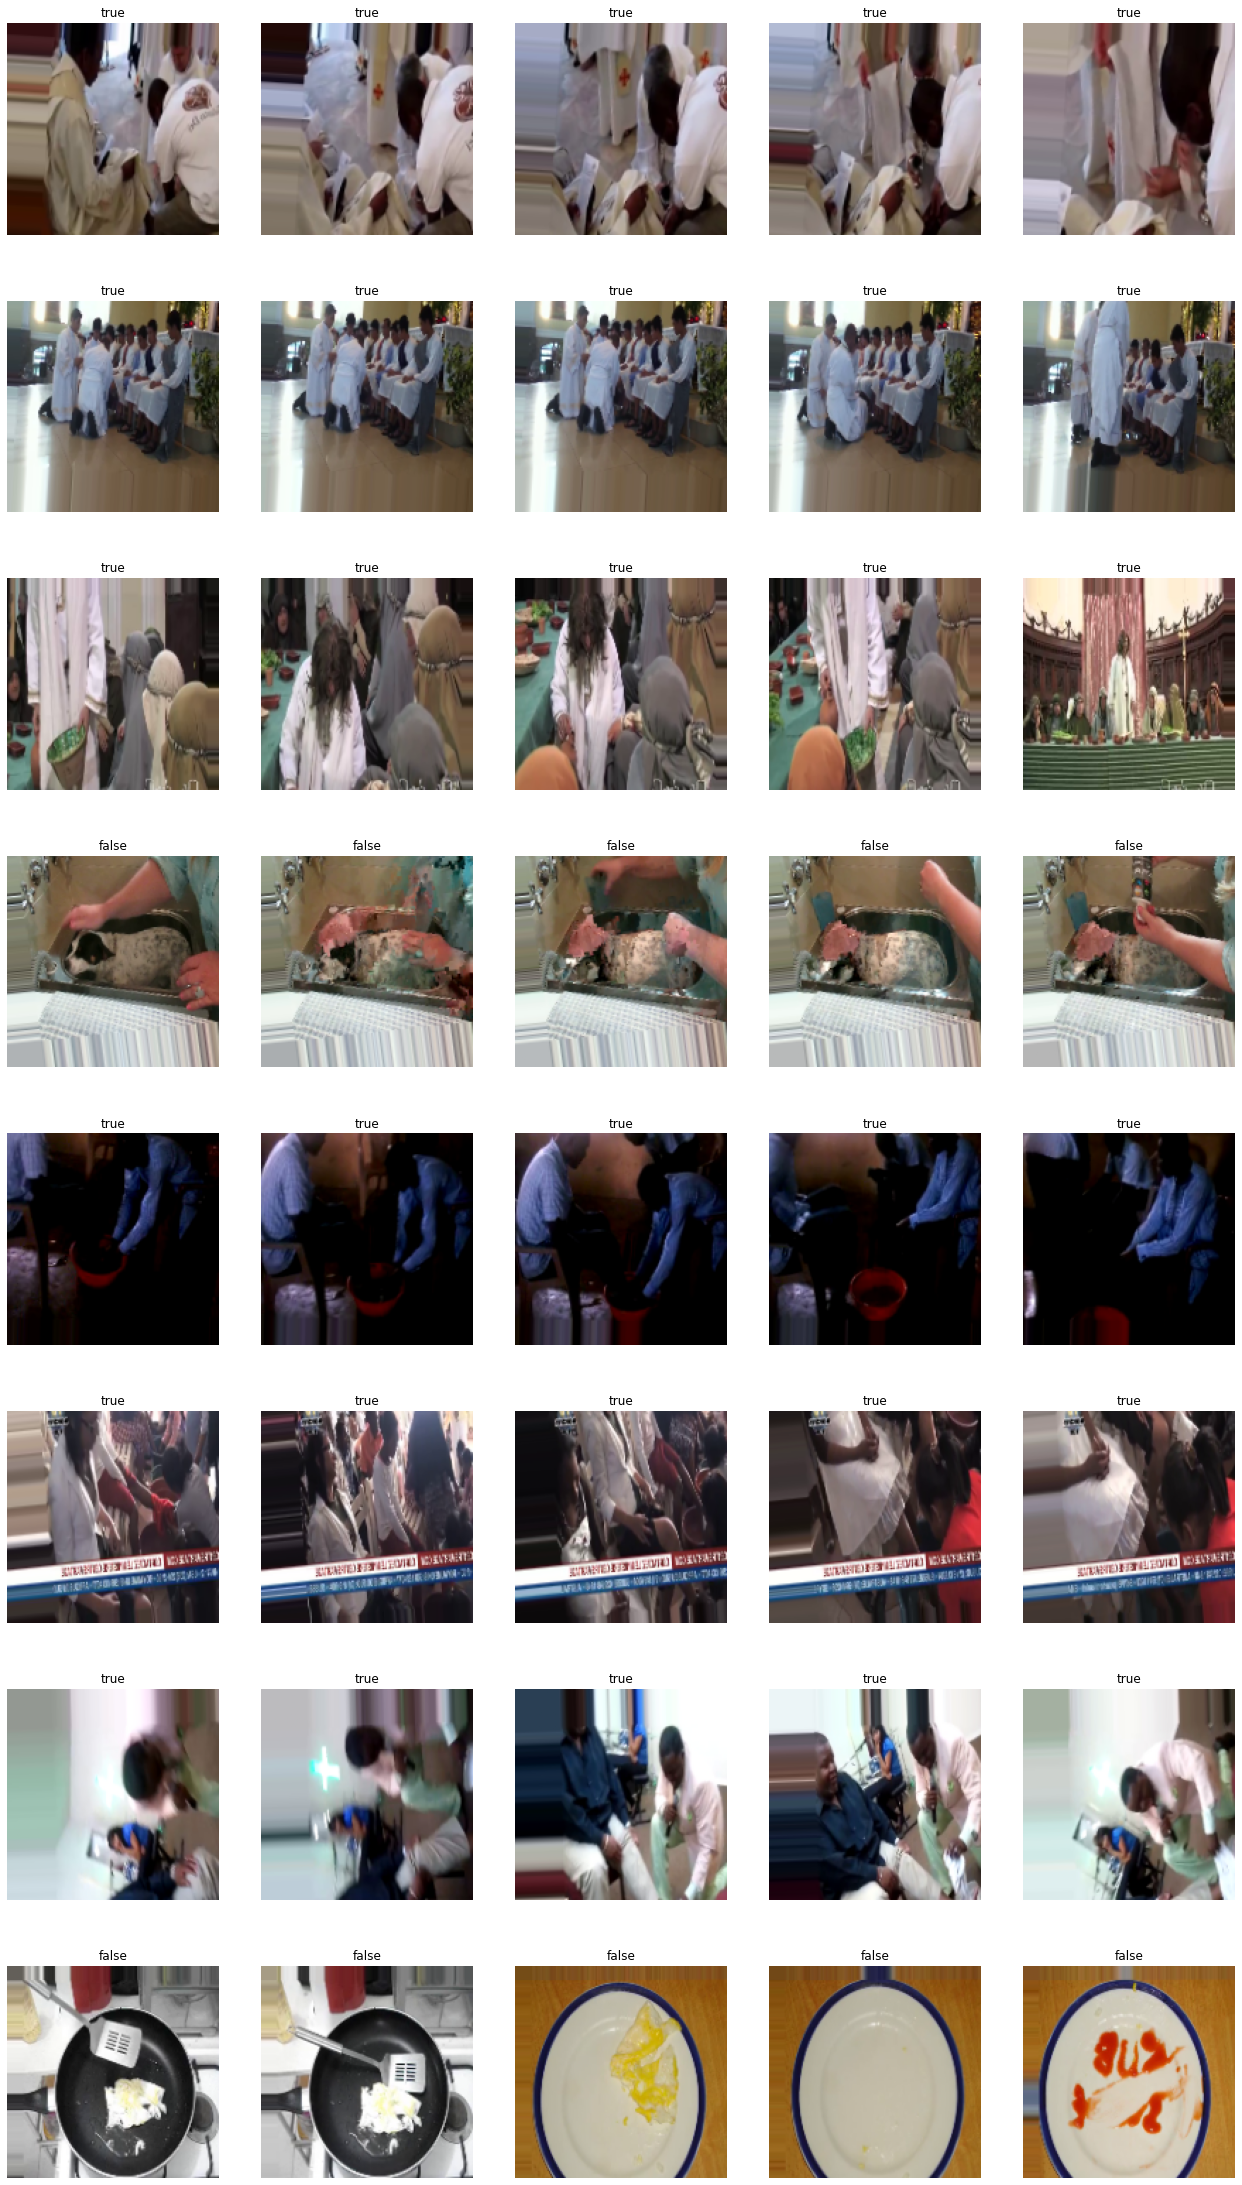

In [ ]:
import keras_video.utils

keras_video.utils.show_sample(train)

Build my model

In [ ]:
from keras.applications import VGG16
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.applications import Xception


In [ ]:

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

def action_model(shape=(NBFRAME, 150, 150, 3), nbout=2):
    
    # Flatten output of conv_base
    mod = Sequential()
    mod.add(conv_base)
    mod.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(mod, input_shape=shape))
    # LSTM for time series
    model.add(LSTM(64))
    # Build the classifier
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 2048)           20861480  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                540928    
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_______________________________________________________

In [ ]:
from keras.optimizers import Adam

optimizer= Adam(0.0001)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train

Try 1: split_val=.2, Adam(0.001), steps_per_epoch = 20, epochs=35, validation_steps=10, NBFRAME = 15
, BS = 15. ACCURACY: 72




Try 1: split_val=.2, Adam(0.0001), steps_per_epoch = 20, epochs=30, validation_steps=10, NBFRAME = 5
, BS = 8. ACCURACY: 74.7

try 3: lr = 0.001 LSTM

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'washingfeet_Xcep_sub10.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

history = model.fit(train,
                    steps_per_epoch = 35, #23 43
                    epochs=30, #can change
                   # batch_size=8,
                    callbacks=callbacks,
                    validation_data=val,
                    validation_steps=10)

Epoch 1/30
24/35 [===================>..........] - ETA: 27s - loss: 0.6978 - accuracy: 0.5100

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.5066

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 130s 3s/step - loss: 0.6982 - accuracy: 0.5062 - val_loss: 0.6862 - val_accuracy: 0.5823
Epoch 2/30
30/35 [========================>.....] - ETA: 10s - loss: 0.6870 - accuracy: 0.5493

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5517

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 86s 2s/step - loss: 0.6869 - accuracy: 0.5521 - val_loss: 0.6757 - val_accuracy: 0.6582
Epoch 3/30
 3/35 [=>............................] - ETA: 1:44 - loss: 0.6727 - accuracy: 0.5833

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.6425

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 57s 2s/step - loss: 0.6730 - accuracy: 0.6415 - val_loss: 0.6471 - val_accuracy: 0.7215
Epoch 4/30
23/35 [==================>...........] - ETA: 19s - loss: 0.6404 - accuracy: 0.7723

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.648.mp4, 0 total, 0 extracted


35/35 [==============================] - 62s 2s/step - loss: 0.6411 - accuracy: 0.7530 - val_loss: 0.6002 - val_accuracy: 0.8000
Epoch 5/30
35/35 [==============================] - 38s 1s/step - loss: 0.6241 - accuracy: 0.7028 - val_loss: 0.5107 - val_accuracy: 0.8625
Epoch 6/30
16/35 [============>.................] - ETA: 16s - loss: 0.5611 - accuracy: 0.7824

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.648.mp4, 0 total, 0 extracted


35/35 [==============================] - 39s 1s/step - loss: 0.5515 - accuracy: 0.7889 - val_loss: 0.4302 - val_accuracy: 0.8625
Epoch 7/30
35/35 [==============================] - 27s 770ms/step - loss: 0.5049 - accuracy: 0.8196 - val_loss: 0.4409 - val_accuracy: 0.7875
Epoch 8/30
35/35 [==============================] - 23s 665ms/step - loss: 0.4871 - accuracy: 0.7986 - val_loss: 0.3596 - val_accuracy: 0.8375
Epoch 9/30
35/35 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8284

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 16s 465ms/step - loss: 0.4443 - accuracy: 0.8284 - val_loss: 0.3206 - val_accuracy: 0.8734
Epoch 10/30
35/35 [==============================] - 14s 414ms/step - loss: 0.4122 - accuracy: 0.8365 - val_loss: 0.3607 - val_accuracy: 0.8625
Epoch 11/30
21/35 [=================>............] - ETA: 4s - loss: 0.3833 - accuracy: 0.8637

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - 14s 398ms/step - loss: 0.3965 - accuracy: 0.8563 - val_loss: 0.3270 - val_accuracy: 0.8500
Epoch 12/30
35/35 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8506

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 12s 336ms/step - loss: 0.3663 - accuracy: 0.8499 - val_loss: 0.2911 - val_accuracy: 0.8861
Epoch 13/30
35/35 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8118

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 11s 296ms/step - loss: 0.4291 - accuracy: 0.8121 - val_loss: 0.4042 - val_accuracy: 0.8000
Epoch 14/30
35/35 [==============================] - 11s 316ms/step - loss: 0.3314 - accuracy: 0.8605 - val_loss: 0.3479 - val_accuracy: 0.8375
Epoch 15/30
 7/35 [=====>........................] - ETA: 8s - loss: 0.2900 - accuracy: 0.8916

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.648.mp4, 0 total, 0 extracted


35/35 [==============================] - 12s 318ms/step - loss: 0.3600 - accuracy: 0.8474 - val_loss: 0.2444 - val_accuracy: 0.9000
Epoch 16/30
35/35 [==============================] - 8s 228ms/step - loss: 0.3105 - accuracy: 0.8711 - val_loss: 0.3071 - val_accuracy: 0.8500
Epoch 17/30
35/35 [==============================] - 9s 253ms/step - loss: 0.4287 - accuracy: 0.8085 - val_loss: 0.2200 - val_accuracy: 0.9125
Epoch 18/30
35/35 [==============================] - 8s 226ms/step - loss: 0.3283 - accuracy: 0.8953 - val_loss: 0.3983 - val_accuracy: 0.8250
Epoch 19/30
35/35 [==============================] - 8s 239ms/step - loss: 0.3706 - accuracy: 0.8272 - val_loss: 0.3176 - val_accuracy: 0.8625
Epoch 20/30
35/35 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8838

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 9s 255ms/step - loss: 0.3186 - accuracy: 0.8834 - val_loss: 0.2309 - val_accuracy: 0.8987
Epoch 21/30
35/35 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8829

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - 8s 223ms/step - loss: 0.2809 - accuracy: 0.8826 - val_loss: 0.2237 - val_accuracy: 0.8875
Epoch 22/30
12/35 [=========>....................] - ETA: 4s - loss: 0.3220 - accuracy: 0.9107

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - 8s 228ms/step - loss: 0.3369 - accuracy: 0.8735 - val_loss: 0.2893 - val_accuracy: 0.8500
Epoch 23/30
31/35 [=========================>....] - ETA: 0s - loss: 0.2873 - accuracy: 0.8688

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.158.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8703

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 8s 224ms/step - loss: 0.2879 - accuracy: 0.8707 - val_loss: 0.3788 - val_accuracy: 0.8354
Epoch 24/30
35/35 [==============================] - ETA: 0s - loss: 0.3469 - accuracy: 0.8669

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 8s 226ms/step - loss: 0.3464 - accuracy: 0.8668 - val_loss: 0.3377 - val_accuracy: 0.8608
Epoch 25/30
11/35 [========>.....................] - ETA: 5s - loss: 0.3684 - accuracy: 0.8315

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.648.mp4, 0 total, 0 extracted


35/35 [==============================] - 8s 230ms/step - loss: 0.3148 - accuracy: 0.8683 - val_loss: 0.3638 - val_accuracy: 0.8625
Epoch 26/30
35/35 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.9137

Frame count is not OK for video /content/washingfeet/content/kinetics700/train/false/not washing feet.26.mp4, 2 total, 2 extracted


35/35 [==============================] - 8s 227ms/step - loss: 0.2862 - accuracy: 0.9132 - val_loss: 0.4118 - val_accuracy: 0.8481
Epoch 27/30
35/35 [==============================] - 8s 240ms/step - loss: 0.3223 - accuracy: 0.8692 - val_loss: 0.2817 - val_accuracy: 0.8625

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 28/30
35/35 [==============================] - 8s 221ms/step - loss: 0.2544 - accuracy: 0.8908 - val_loss: 0.3503 - val_accuracy: 0.8625
Epoch 29/30
35/35 [==============================] - 8s 220ms/step - loss: 0.3019 - accuracy: 0.9053 - val_loss: 0.1581 - val_accuracy: 0.9500
Epoch 30/30
35/35 [==============================] - 8s 221ms/step - loss: 0.2908 - accuracy: 0.8929 - val_loss: 0.2100 - val_accuracy: 0.9125


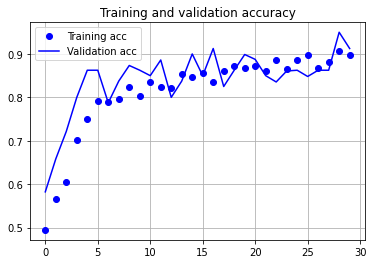

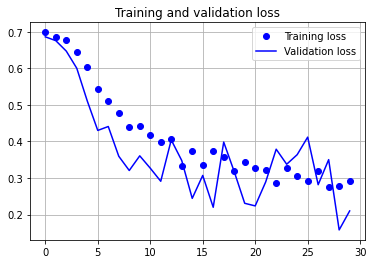

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8
glob_pattern='/content/washingfeet/content/kinetics700/test/{classname}/*.mp4'

# make video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 83 files for train


In [ ]:
model.evaluate(test)

 3/10 [========>.....................] - ETA: 18s - loss: 0.3643 - accuracy: 0.8333

Frame count is not OK for video /content/washingfeet/content/kinetics700/test/false/not washing feet.6.mp4, 0 total, 0 extracted


10/10 [==============================] - 23s 3s/step - loss: 0.4030 - accuracy: 0.8228


[0.40301278233528137, 0.8227847814559937]

In [ ]:
!cp -a '/content/washingfeet_Xcep_sub10.h5' '/content/drive/MyDrive/Colab Notebooks/Submission 10'